### Context
The dataset contains historical product demand for a manufacturing company with footprints globally. The company provides thousands of products within dozens of product categories. There are four central warehouses to ship products within the region it is responsible for. Since the products are manufactured in different locations all over the world, it normally takes more than one month to ship products via ocean to different central warehouses. If forecasts for each product in different central with reasonable accuracy for the monthly demand for month after next can be achieved, it would be beneficial to the company in multiple ways.

### Content
Historical Product Demand.csv - CSV data file containing product demand for encoded product id's

### Acknowledgements
This dataset is all real-life data and products/warehouse and category information encoded.

### Inspiration
Is it possible to make forecasts for thousands of products (some of them are highly variable in terms of monthly demand) for the the month after next?

Data author on Kaggle - Sanjoy Biswas

https://www.kaggle.com/code/imsanjoykb/forecast-order-demand-and-visualization/notebook

Many portions of this code are built on the work done by Sanjoy. The purpose of this notebook is to learn how the SARIMAX model works and how different adjustments can affect the overall validity of the results from the model.

In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import datetime

#Importing Graphical Items
import seaborn as sns
import matplotlib.pyplot as plt

# To ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Download data set
df = pd.read_csv("Historical Product Demand.csv")

In [3]:
#Checking head of data set.
df.head()

Product_Code Warehouse Product_Category       Date Order_Demand
0  Product_0993    Whse_J     Category_028  2012/7/27         100 
1  Product_0979    Whse_J     Category_028  2012/1/19         500 
2  Product_0979    Whse_J     Category_028   2012/2/3         500 
3  Product_0979    Whse_J     Category_028   2012/2/9         500 
4  Product_0979    Whse_J     Category_028   2012/3/2         500

In [4]:
#Arranging table in order from earliest to latest date
df = df.sort_values("Date")
df.reset_index(inplace = True, drop = True)

In [5]:
df.head(10)

Product_Code Warehouse Product_Category        Date Order_Demand
0  Product_0965    Whse_A     Category_006    2011/1/8           2 
1  Product_0412    Whse_S     Category_007  2011/10/20          (2)
2  Product_0125    Whse_S     Category_011  2011/10/20          (2)
3  Product_0642    Whse_C     Category_019  2011/10/31           3 
4  Product_2137    Whse_S     Category_009  2011/11/18         (25)
5  Product_0288    Whse_S     Category_021  2011/11/18         (50)
6  Product_0131    Whse_S     Category_021  2011/11/18         (12)
7  Product_2138    Whse_S     Category_009  2011/11/18         (49)
8  Product_2143    Whse_S     Category_009  2011/11/18         (25)
9  Product_0980    Whse_A     Category_028  2011/11/18        4000

In [6]:
df.tail(10)

Product_Code Warehouse Product_Category Date Order_Demand
1048565  Product_1422    Whse_A     Category_019  NaN        (800)
1048566  Product_1423    Whse_A     Category_019  NaN       (1500)
1048567  Product_1424    Whse_A     Category_019  NaN        (200)
1048568  Product_1541    Whse_A     Category_019  NaN        (200)
1048569  Product_1402    Whse_A     Category_019  NaN        (600)
1048570  Product_1464    Whse_A     Category_019  NaN        (900)
1048571  Product_1541    Whse_A     Category_019  NaN        (200)
1048572  Product_1388    Whse_A     Category_019  NaN        (300)
1048573  Product_1541    Whse_A     Category_019  NaN        (300)
1048574  Product_1509    Whse_A     Category_019  NaN        (200)

In [7]:
#Remove each data point before 2012/01/01 and after 2017/01/01
#Data errors show in 2011 data, and 2017 data is very new and incomplete on monthly scale
df = df[(df["Date"] >= "2012-01-01") & (df["Date"] < "2017-01-01")]
df.reset_index(drop = True, inplace = True)

If indicies are not reset, then they stay out of order and are difficult to use for locating.

In [8]:
#All order demand values showing as object - identify non-numeric features in data set
Float_Order = []

for i in range(0,len(df)):
    try:
        Float_Order.append(float(df["Order_Demand"][i]))
    except ValueError:
        Float_Order.append("Error")

data = df.copy()
data["Order_Demand"] = Float_Order

In [9]:
#Create index list of error columns
index_list = list(data[(data["Order_Demand"] == "Error")].index)

In [10]:
#Identify error values in original data set
df["Order_Demand"][index_list].head(20)

142         (5)
337        (20)
412        (25)
420        (25)
503        (25)
968       (100)
1089      (500)
1120     (2000)
1138      (300)
1442     (5000)
1443    (10000)
1496      (300)
1652       (10)
2022        (3)
2027        (3)
2028        (3)
2030       (70)
2270        (1)
2539       (12)
2689        (5)
Name: Order_Demand, dtype: object

The non-numeric features of the data set are numbers in (Val) notation. This is genearlly used to show a negative value, or in this case, negative sales demand at that time. Will convert to negative values and proceed. 

In [11]:
#Replace "(Val)" with a "-Val" so that the column can be converted to int64
df["Order_Demand"] = df["Order_Demand"].str.replace('(',"-")
df["Order_Demand"] = df["Order_Demand"].str.replace(')',"")
df["Order_Demand"] = df["Order_Demand"].astype("int64")

#Convert Date column to type Date
df["Date"]= pd.to_datetime(df["Date"])

In [12]:
#Verifying number converstions worked and that there are not other null values present.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1036643 entries, 0 to 1036642
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Product_Code      1036643 non-null  object        
 1   Warehouse         1036643 non-null  object        
 2   Product_Category  1036643 non-null  object        
 3   Date              1036643 non-null  datetime64[ns]
 4   Order_Demand      1036643 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 39.5+ MB


In [13]:
#Viewing statistics from data
df.describe(include = "all").T

count unique                  top    freq      first  \
Product_Code        1036643   2160         Product_1359   16935        NaT   
Warehouse           1036643      4               Whse_J  764215        NaT   
Product_Category    1036643     33         Category_019  470090        NaT   
Date                1036643   1681  2013-09-27 00:00:00    2075 2012-01-01   
Order_Demand      1036643.0    NaN                  NaN     NaN        NaT   

                       last         mean           std       min   25%    50%  \
Product_Code            NaT          NaN           NaN       NaN   NaN    NaN   
Warehouse               NaT          NaN           NaN       NaN   NaN    NaN   
Product_Category        NaT          NaN           NaN       NaN   NaN    NaN   
Date             2016-12-30          NaN           NaN       NaN   NaN    NaN   
Order_Demand            NaT  4915.913461  29026.198785 -999000.0  19.0  300.0   

                     75%        max  
Product_Code         NaN        NaN  
Warehouse            NaN        NaN  
Product_Category     NaN        NaN  
Date                 NaN        NaN  
Order_Demand      2000.0  4000000.0

In [14]:
#Check # of null values
df.isnull().sum()/df.count()

Product_Code        0.0
Warehouse           0.0
Product_Category    0.0
Date                0.0
Order_Demand        0.0
dtype: float64

In [15]:
#Missing data columns very low - remove lines of missing data
df = df.dropna(how = "any", axis = 0)

In [16]:
#Verify null values are removed
df.isnull().sum()

Product_Code        0
Warehouse           0
Product_Category    0
Date                0
Order_Demand        0
dtype: int64

In [17]:
#Viewing statistics from data
df.describe(include = "all", datetime_is_numeric = False).T

count unique                  top    freq      first  \
Product_Code        1036643   2160         Product_1359   16935        NaT   
Warehouse           1036643      4               Whse_J  764215        NaT   
Product_Category    1036643     33         Category_019  470090        NaT   
Date                1036643   1681  2013-09-27 00:00:00    2075 2012-01-01   
Order_Demand      1036643.0    NaN                  NaN     NaN        NaT   

                       last         mean           std       min   25%    50%  \
Product_Code            NaT          NaN           NaN       NaN   NaN    NaN   
Warehouse               NaT          NaN           NaN       NaN   NaN    NaN   
Product_Category        NaT          NaN           NaN       NaN   NaN    NaN   
Date             2016-12-30          NaN           NaN       NaN   NaN    NaN   
Order_Demand            NaT  4915.913461  29026.198785 -999000.0  19.0  300.0   

                     75%        max  
Product_Code         NaN        NaN  
Warehouse            NaN        NaN  
Product_Category     NaN        NaN  
Date                 NaN        NaN  
Order_Demand      2000.0  4000000.0

## Univariate Analysis

In [18]:
df["Warehouse"].value_counts()

Whse_J    764215
Whse_A    142197
Whse_S     88024
Whse_C     42207
Name: Warehouse, dtype: int64

In [19]:
df["Product_Category"].value_counts()

Category_019    470090
Category_005    101582
Category_001     97707
Category_007     82348
Category_021     51950
Category_006     35495
Category_028     30957
Category_011     23199
Category_015     22937
Category_024     20863
Category_009     19720
Category_026     14763
Category_030     12978
Category_032      9288
Category_022      8642
Category_023      7885
Category_018      5237
Category_003      4187
Category_013      3740
Category_020      3465
Category_031      2268
Category_033      1849
Category_008      1560
Category_012      1146
Category_010       976
Category_029       671
Category_017       615
Category_004       324
Category_002        77
Category_016        37
Category_025        35
Category_014        26
Category_027        26
Name: Product_Category, dtype: int64

Category 19, by far, holds the most number of values.

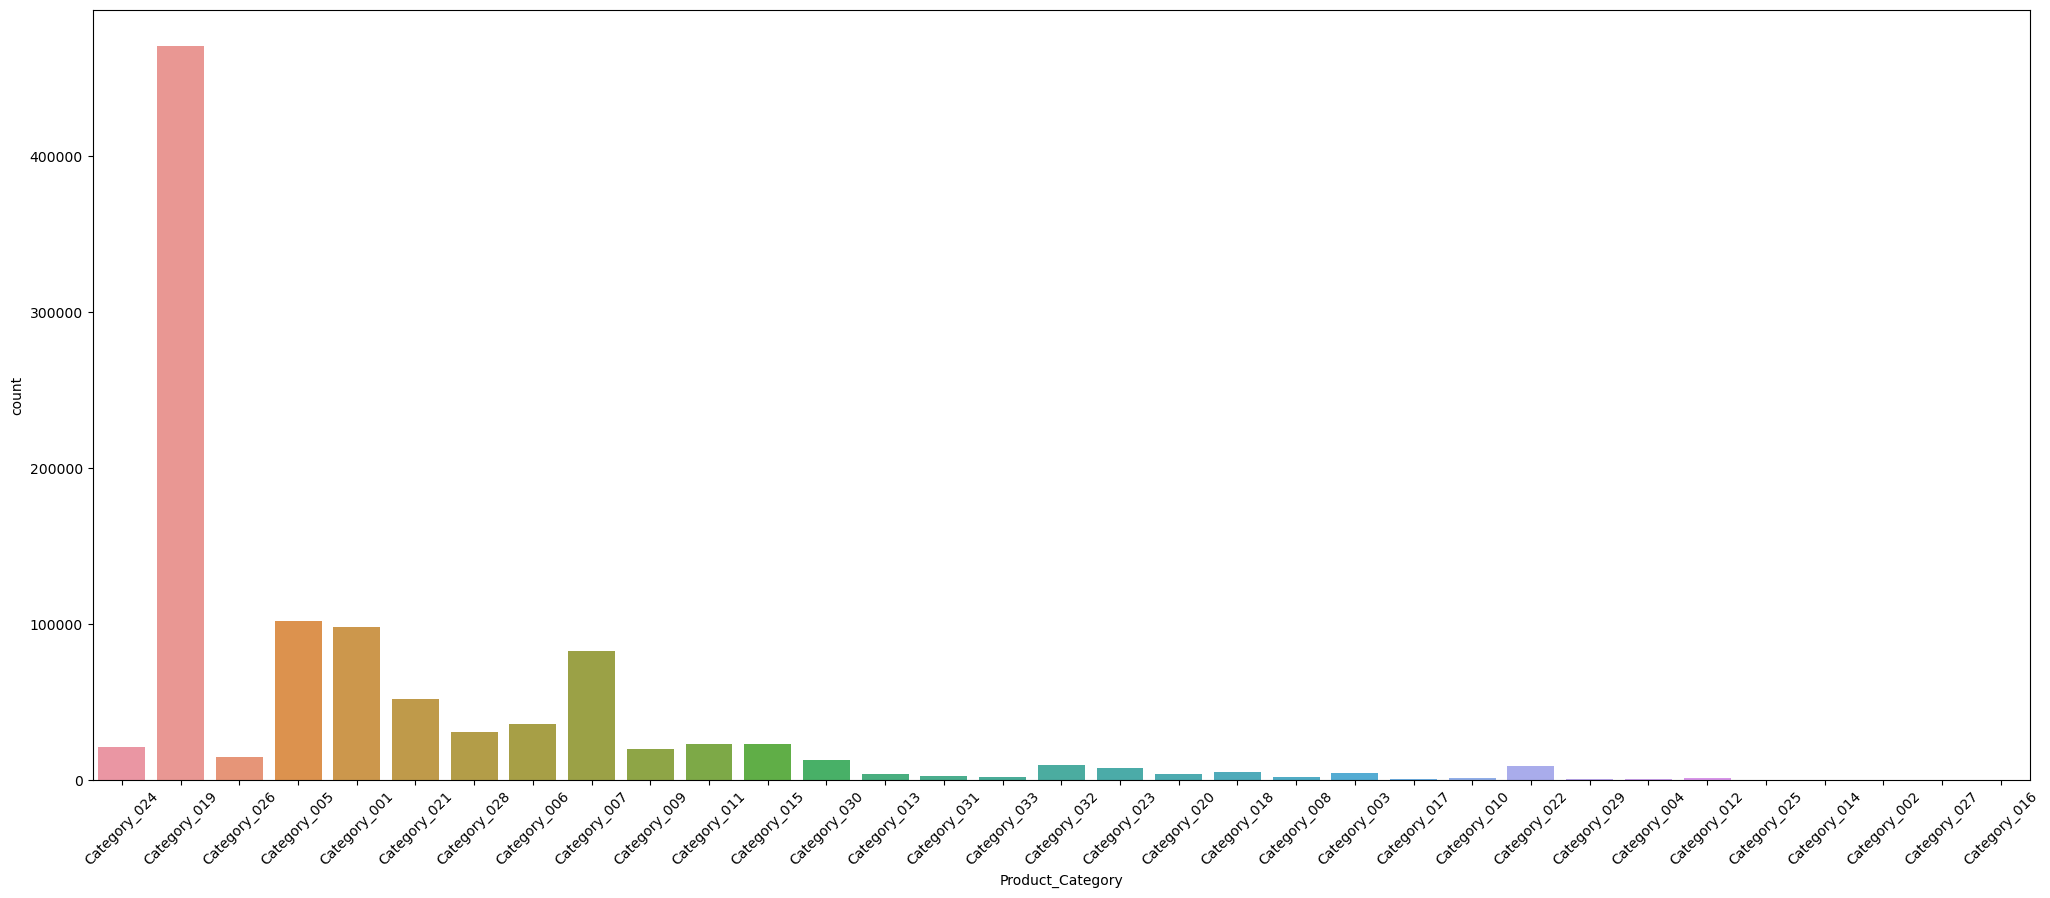

In [20]:
plt.figure(figsize = (25,10))
sns.countplot(data = df, x = df['Product_Category'])
plt.tick_params(axis='x', rotation=45)

## Bivariate Analysis

### Viewing Demand by Warehouse

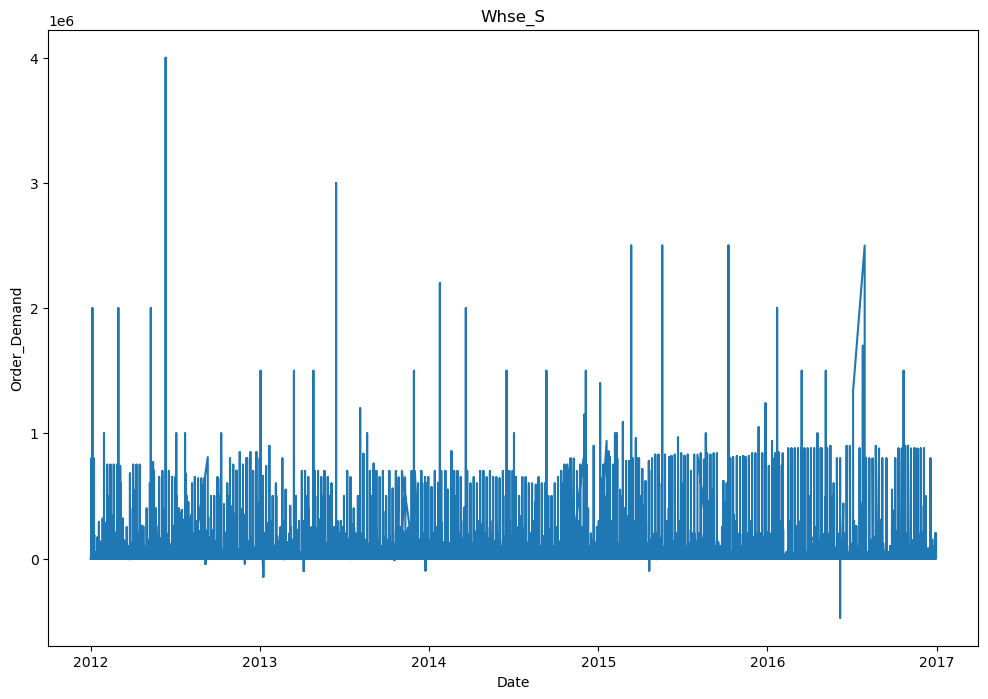

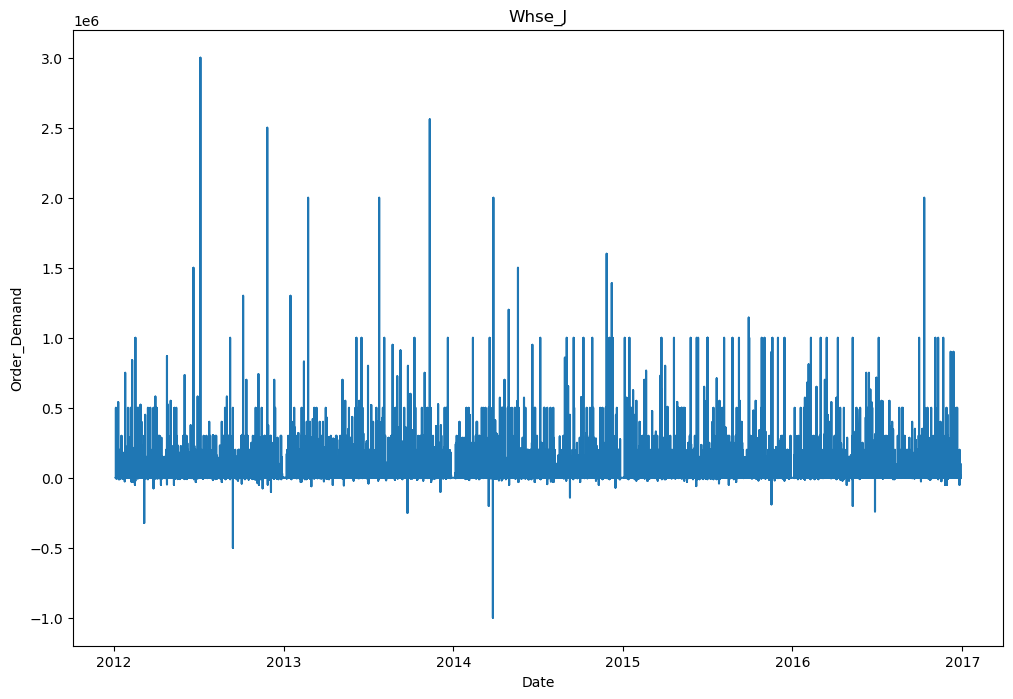

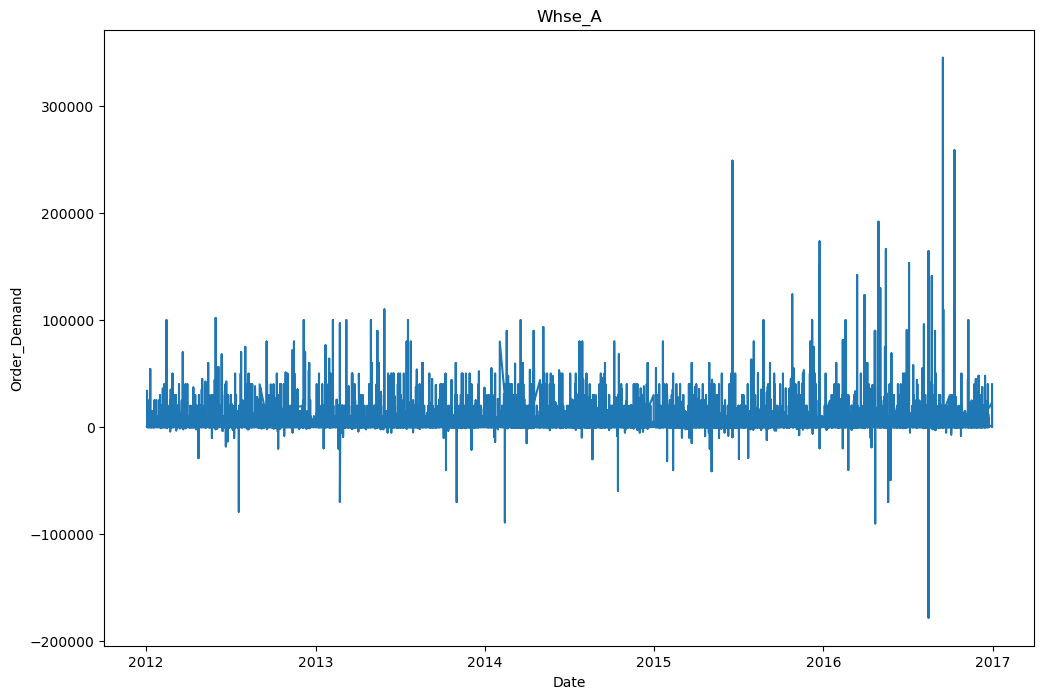

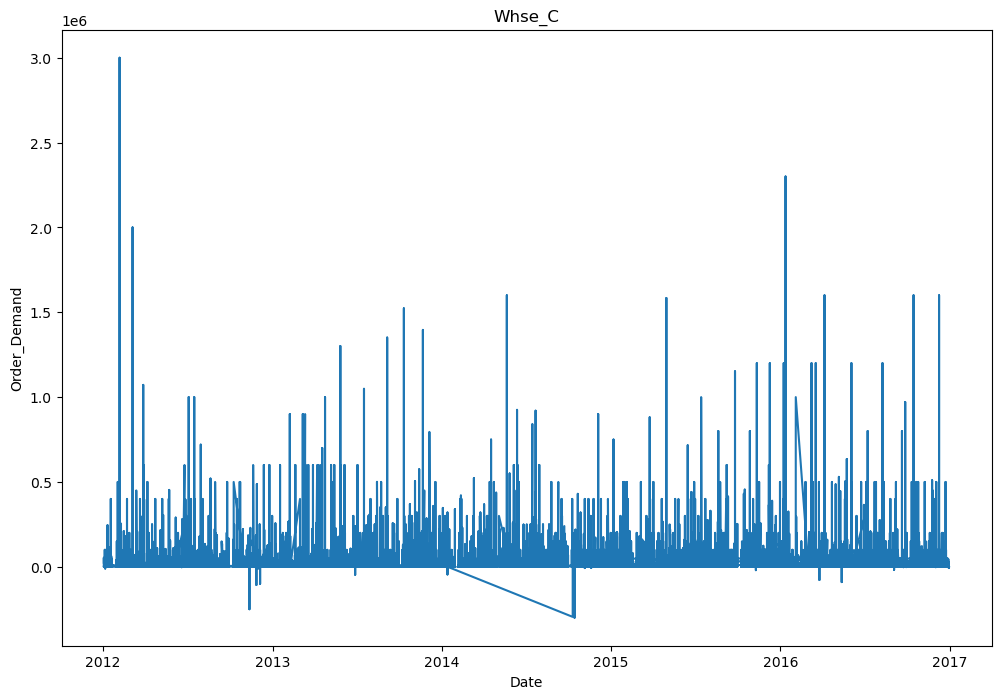

In [21]:
for WHSE in df.Warehouse.unique():
    fig = plt.figure(figsize = (12,8))
    ax = plt.axes()
    plt.xlabel("Date")
    plt.ylabel("Order_Demand")
    plt.title(WHSE)

    ax.plot(df[(df["Warehouse"] == WHSE)]["Date"], df[(df["Warehouse"] == WHSE)]["Order_Demand"])

<AxesSubplot: xlabel='Warehouse', ylabel='Order_Demand'>

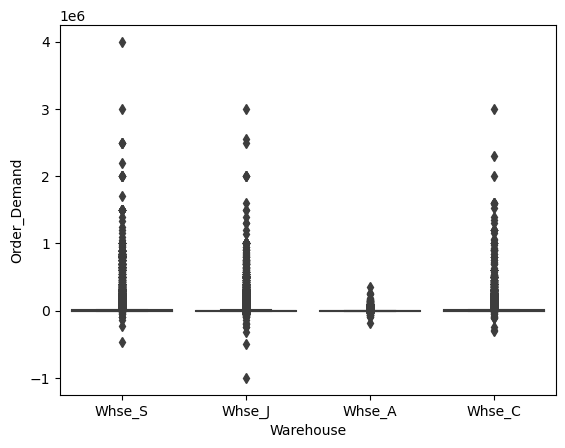

In [22]:
sns.boxplot(df, x = df.Warehouse, y = df.Order_Demand, showfliers = True)

<AxesSubplot: xlabel='Warehouse', ylabel='Order_Demand'>

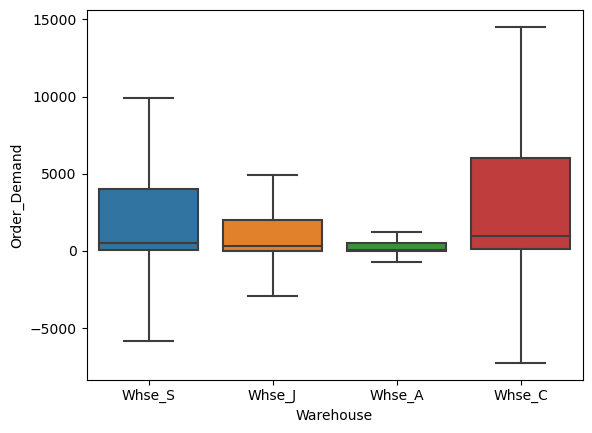

In [23]:
sns.boxplot(df, x = df.Warehouse, y = df.Order_Demand, showfliers = False)

### Order Demand by Product Category

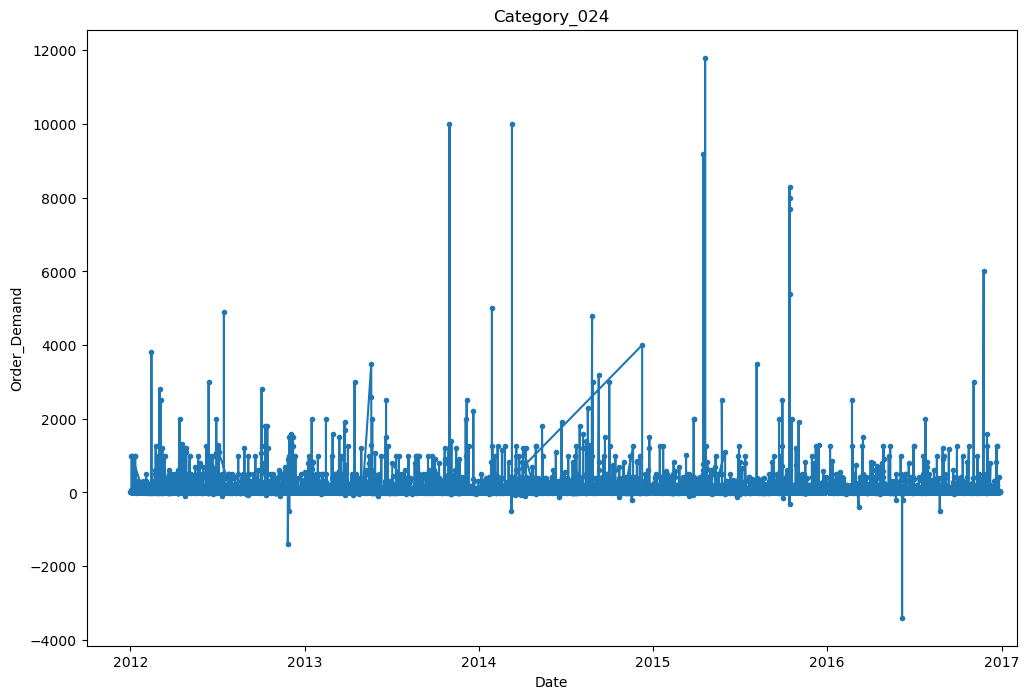

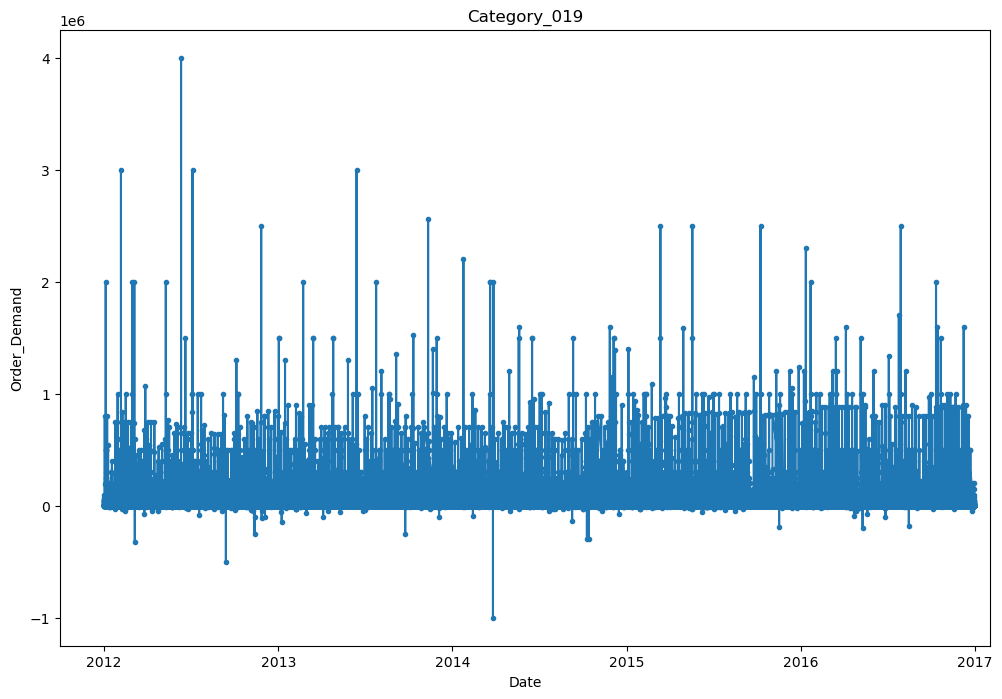

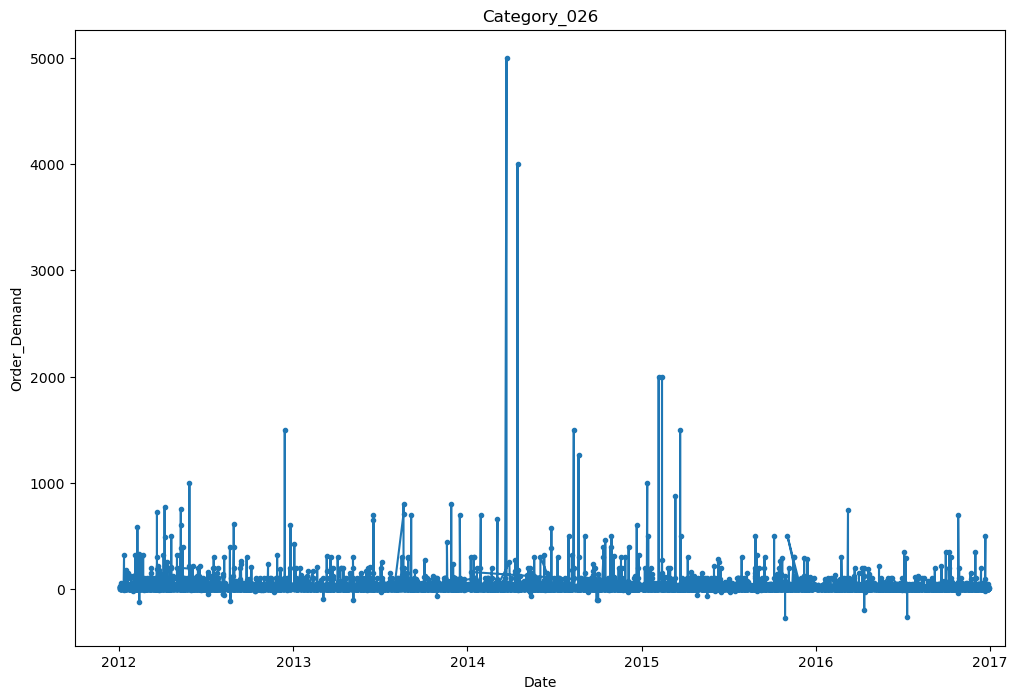

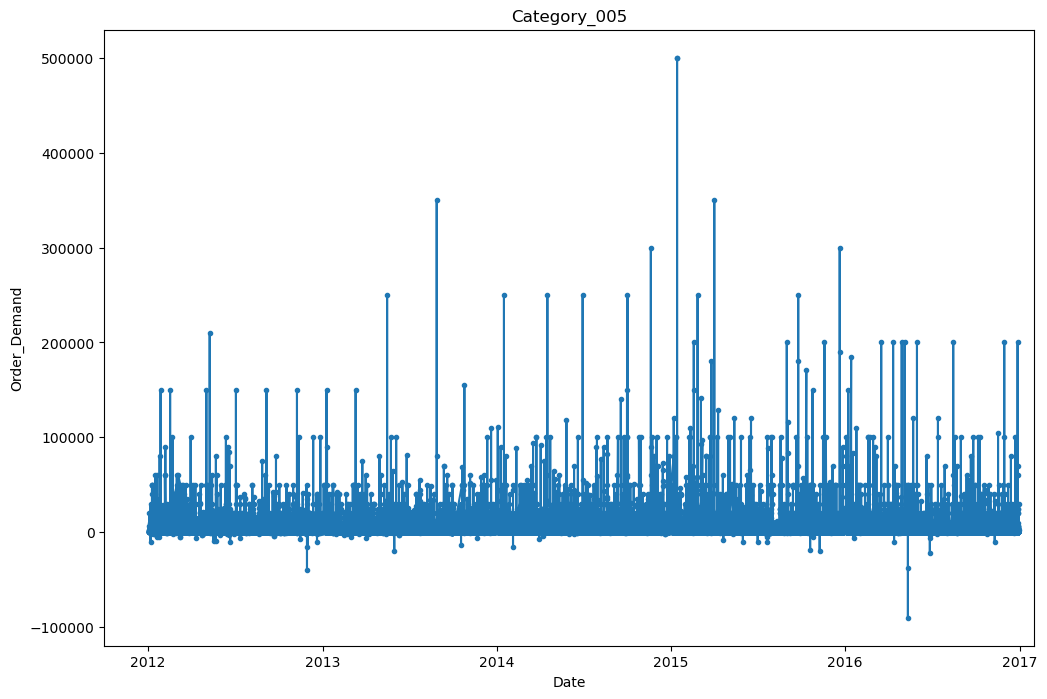

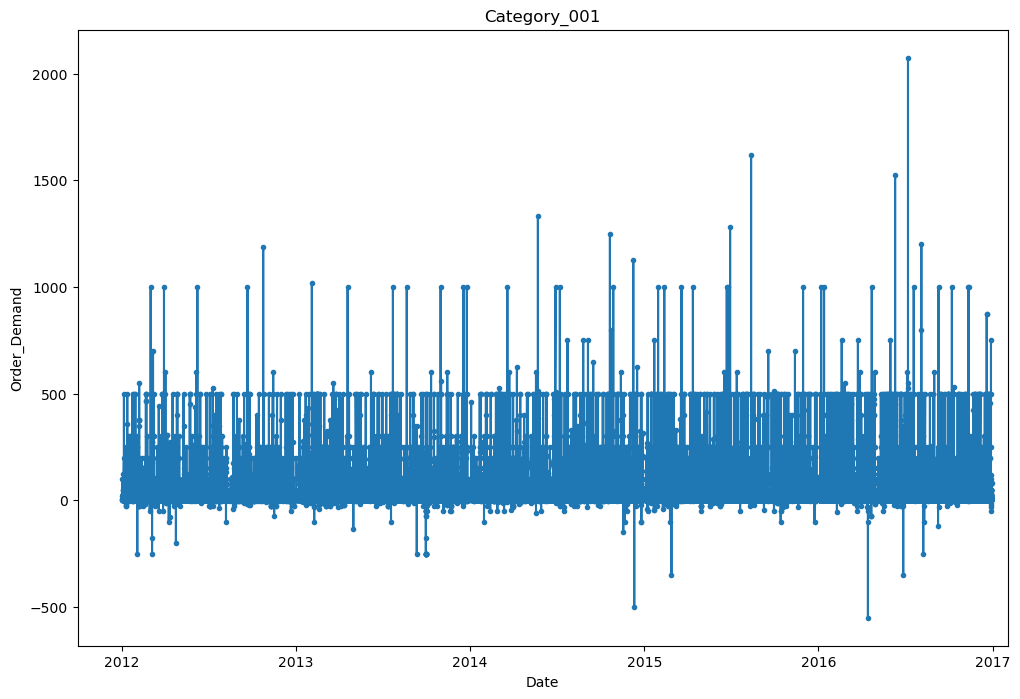

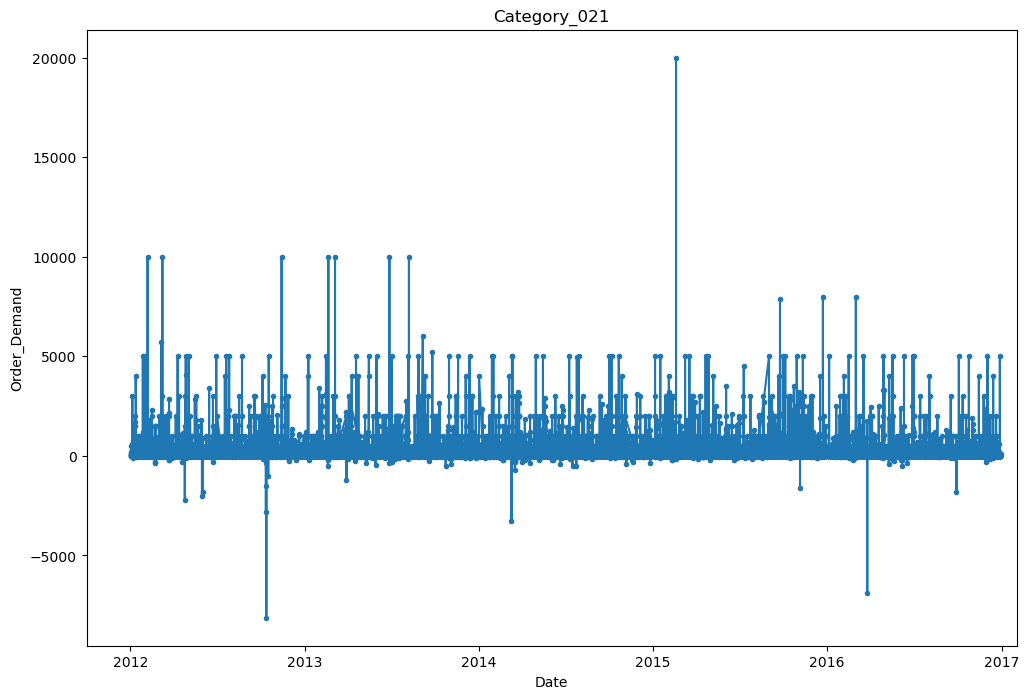

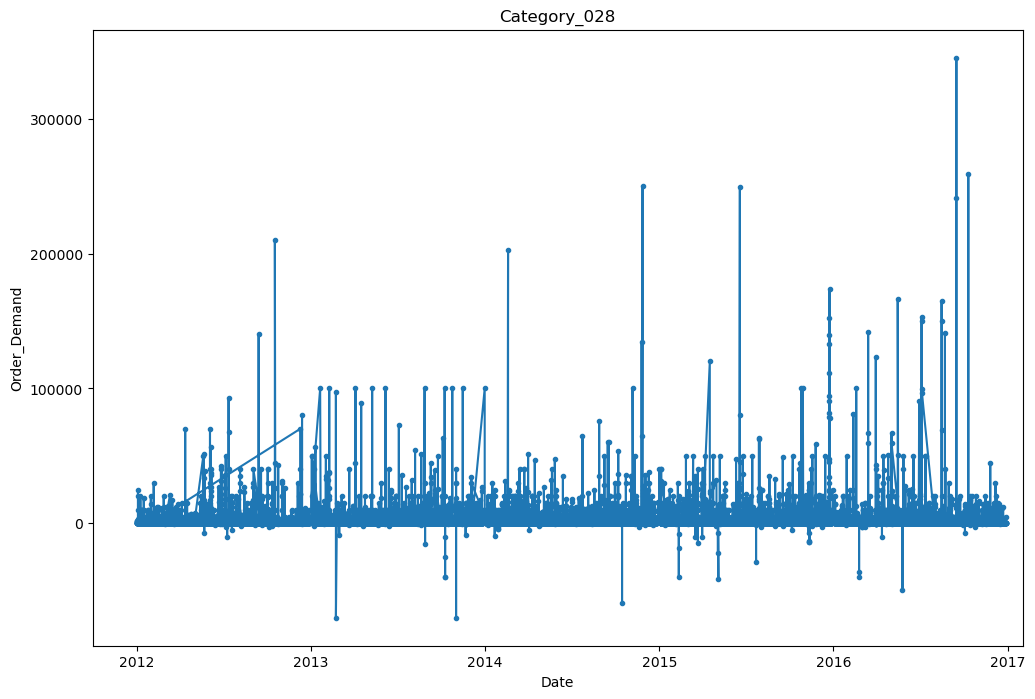

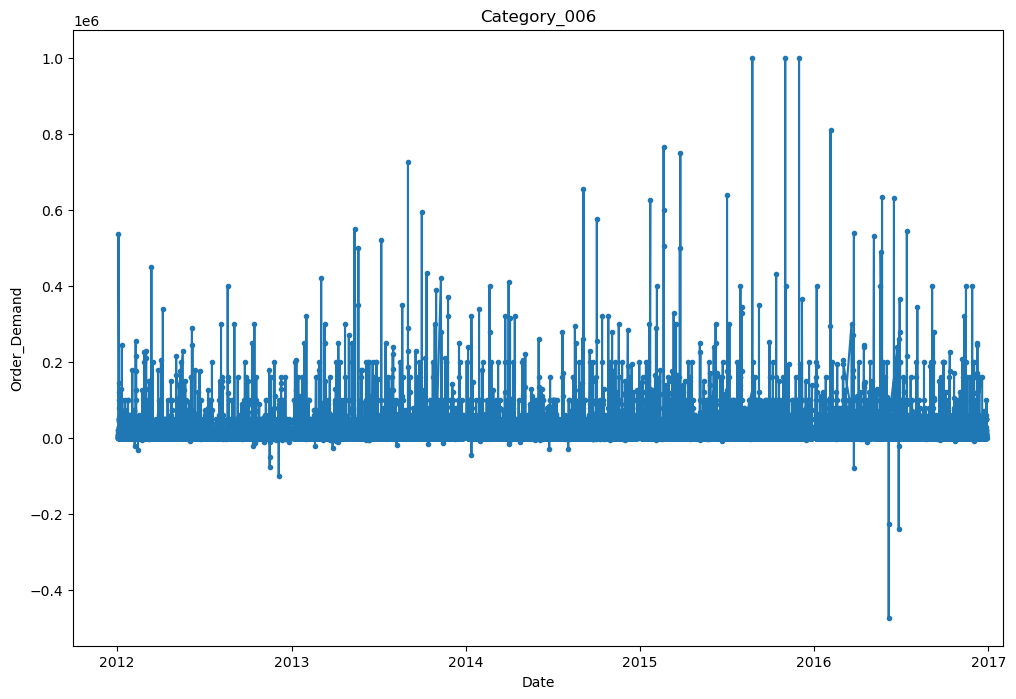

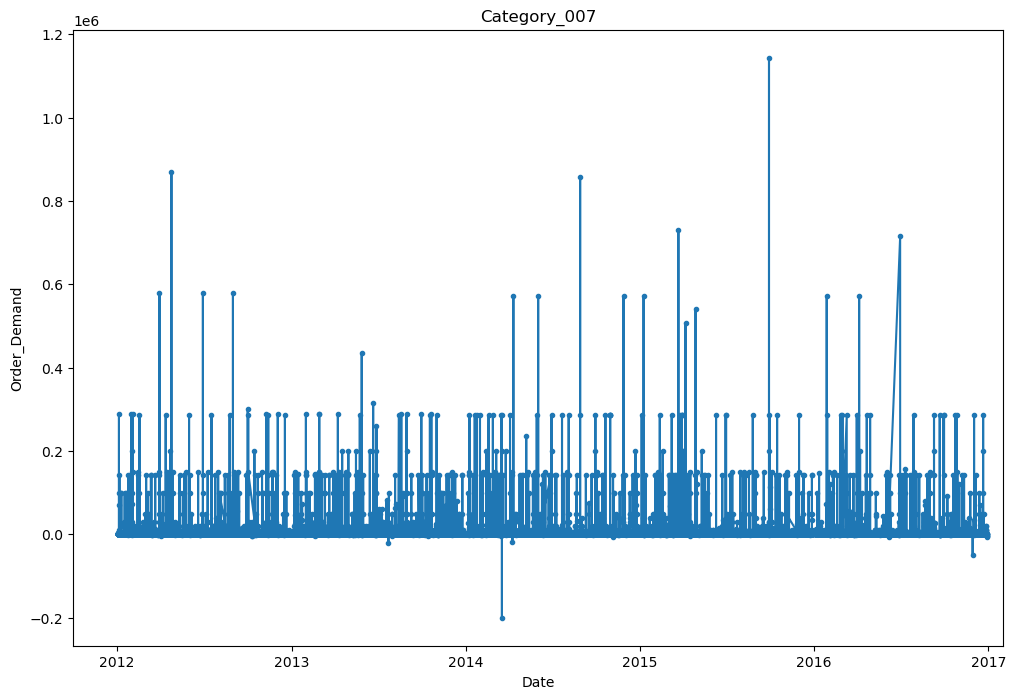

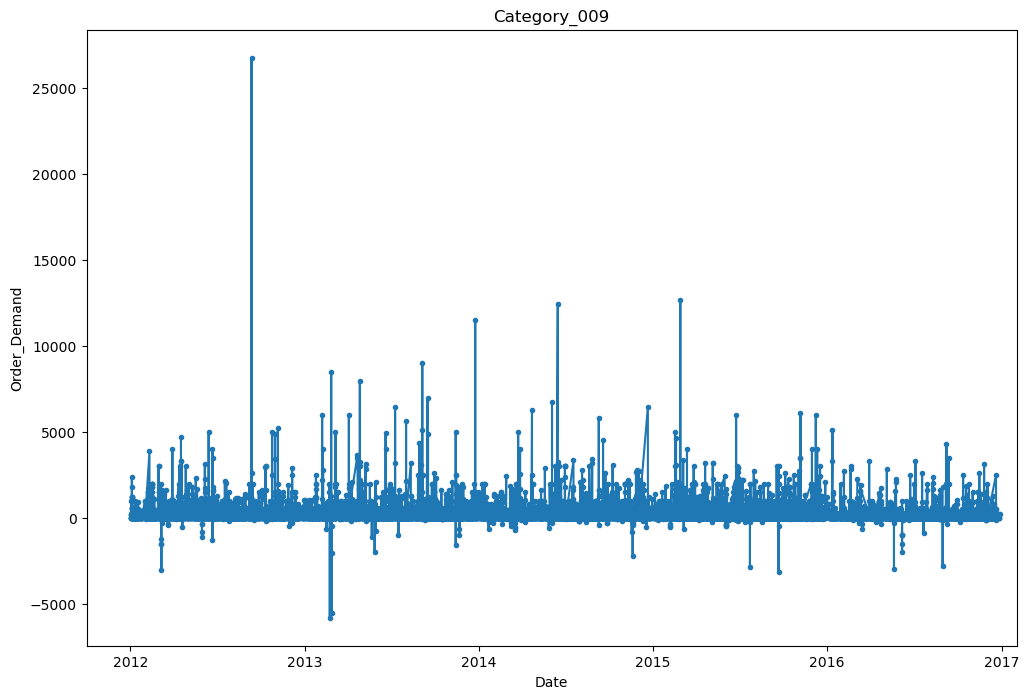

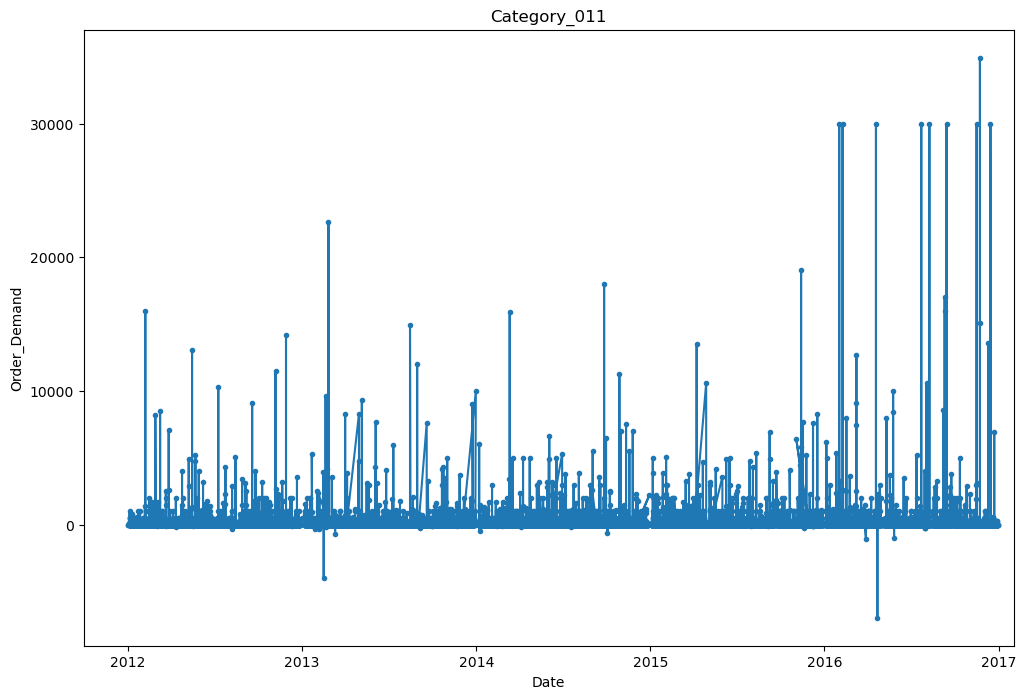

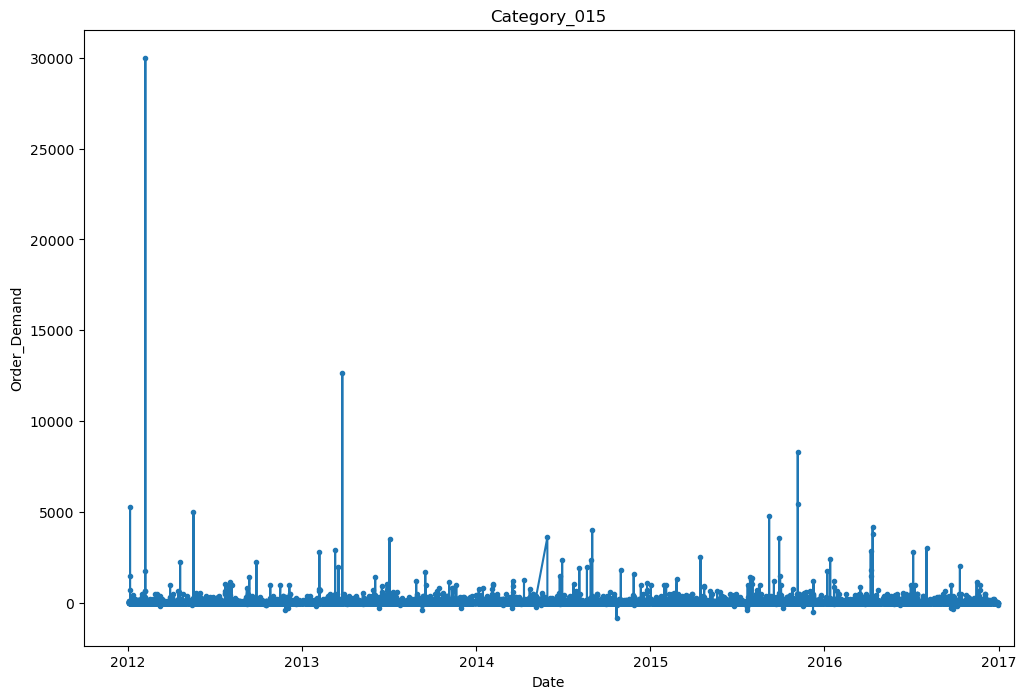

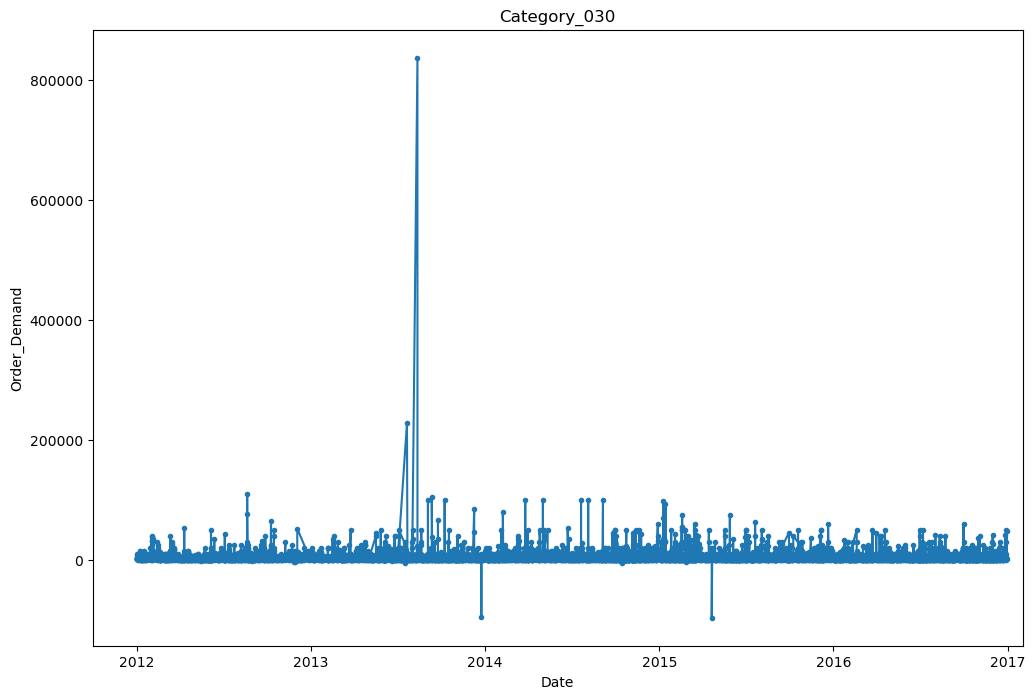

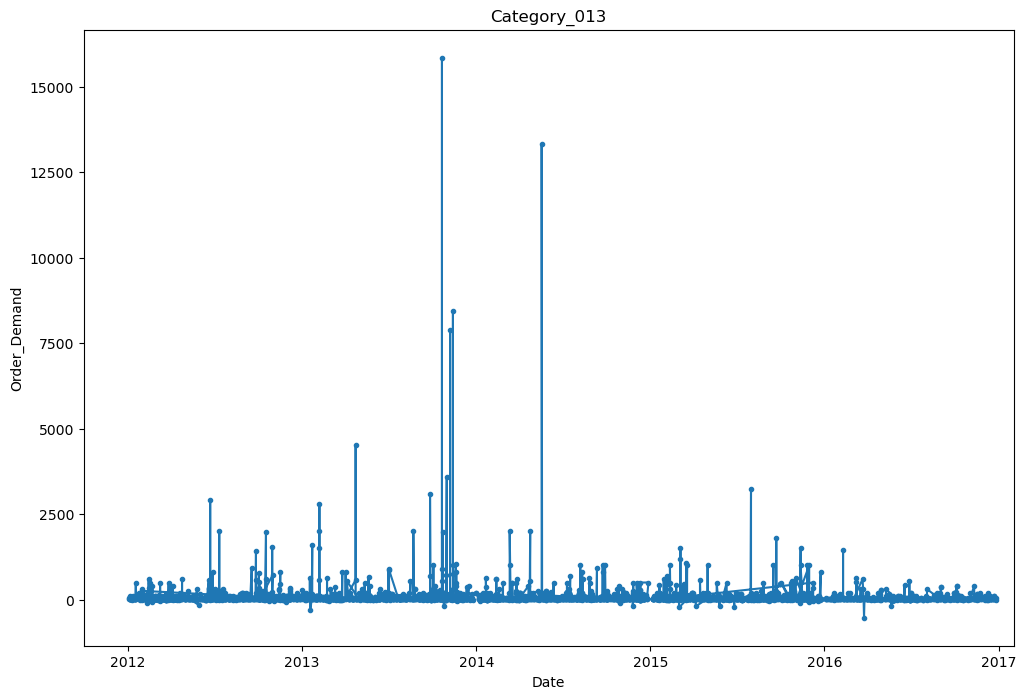

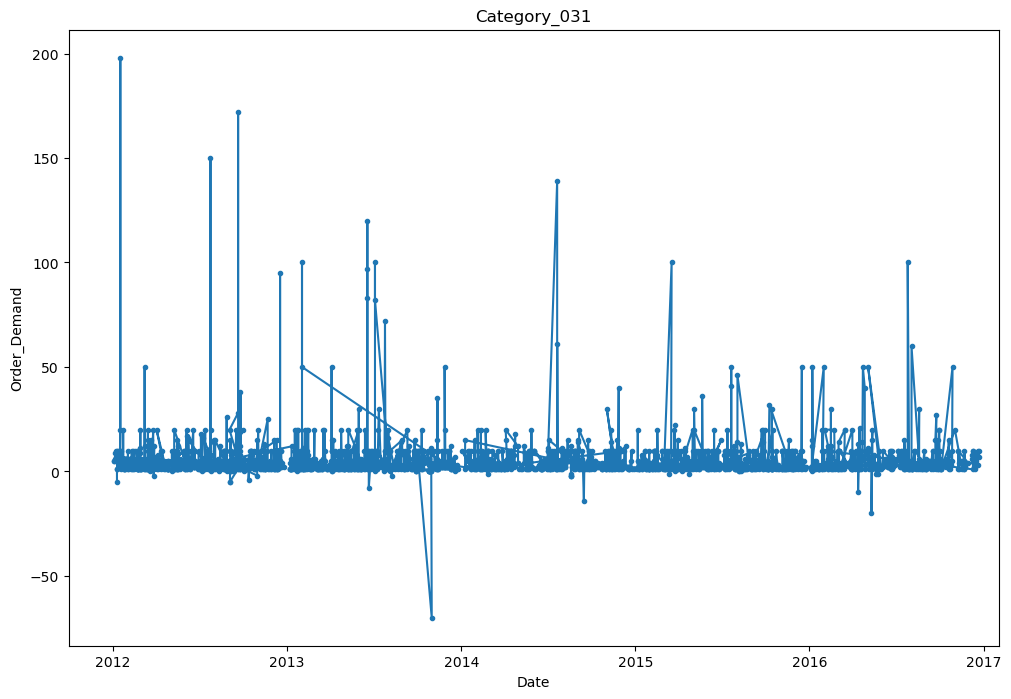

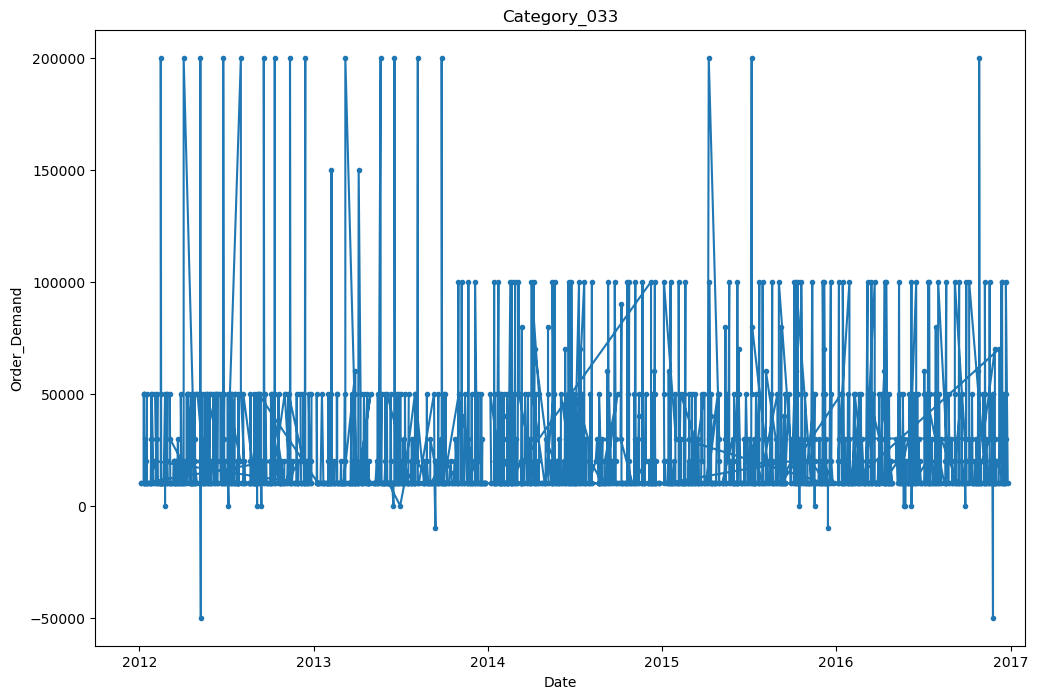

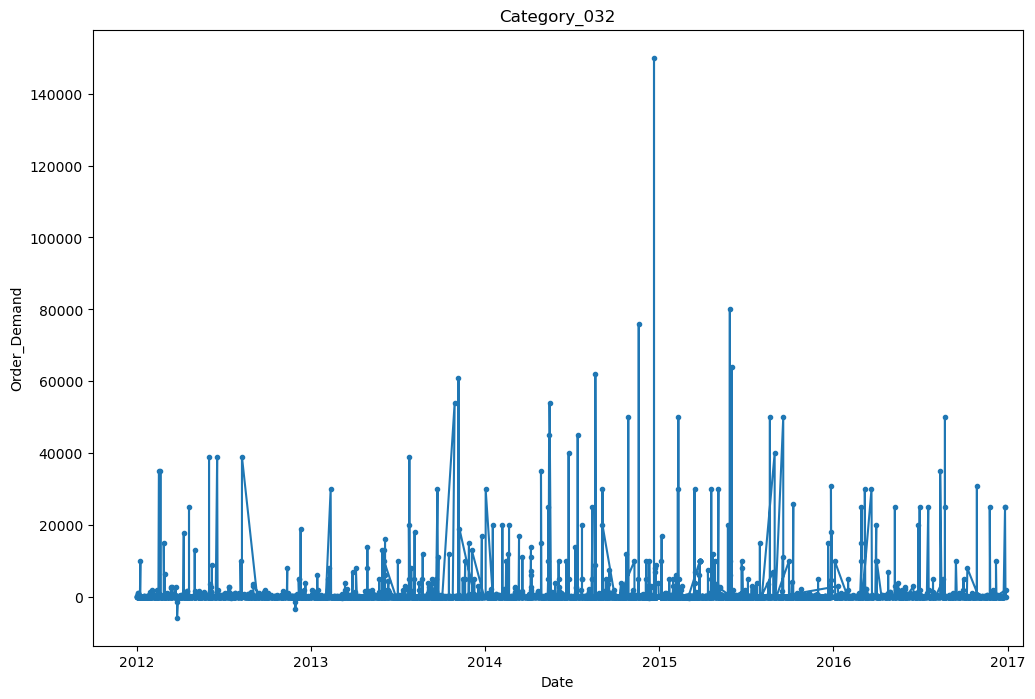

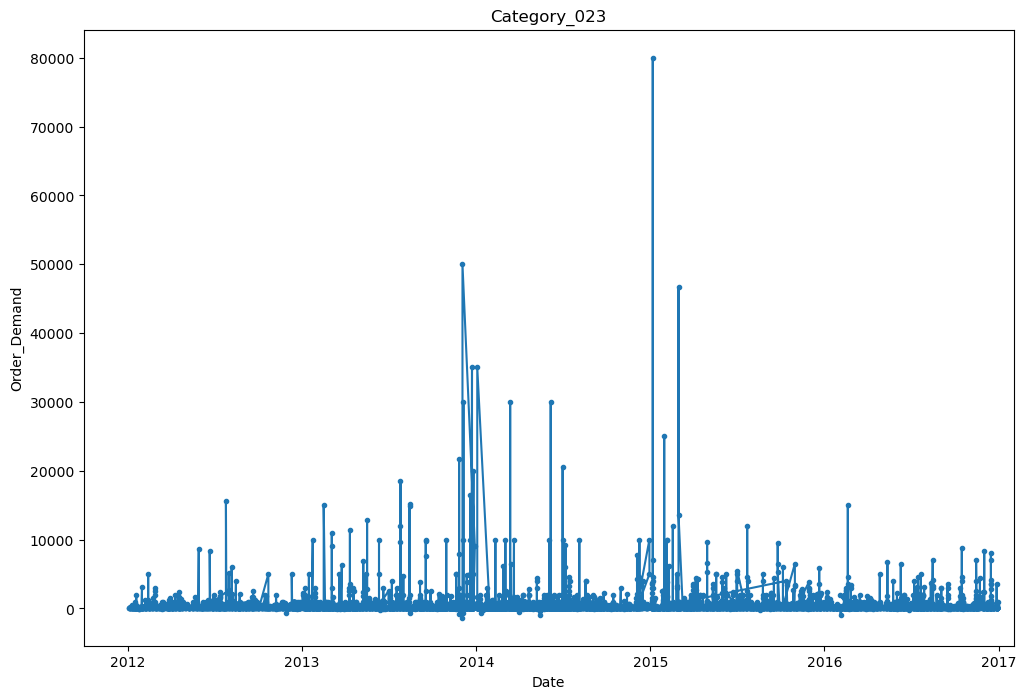

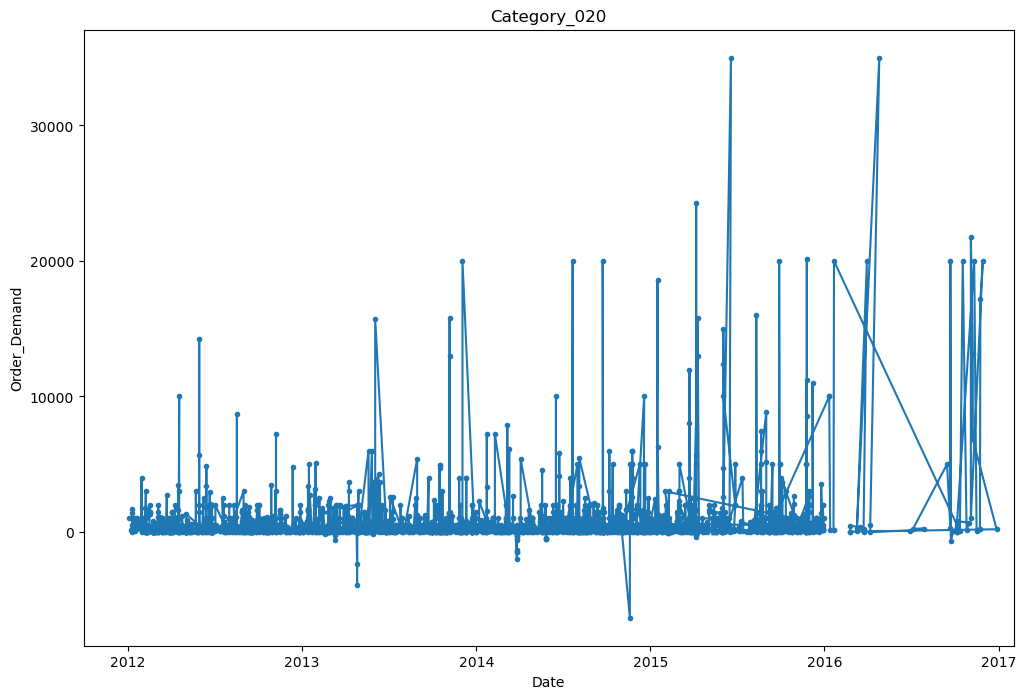

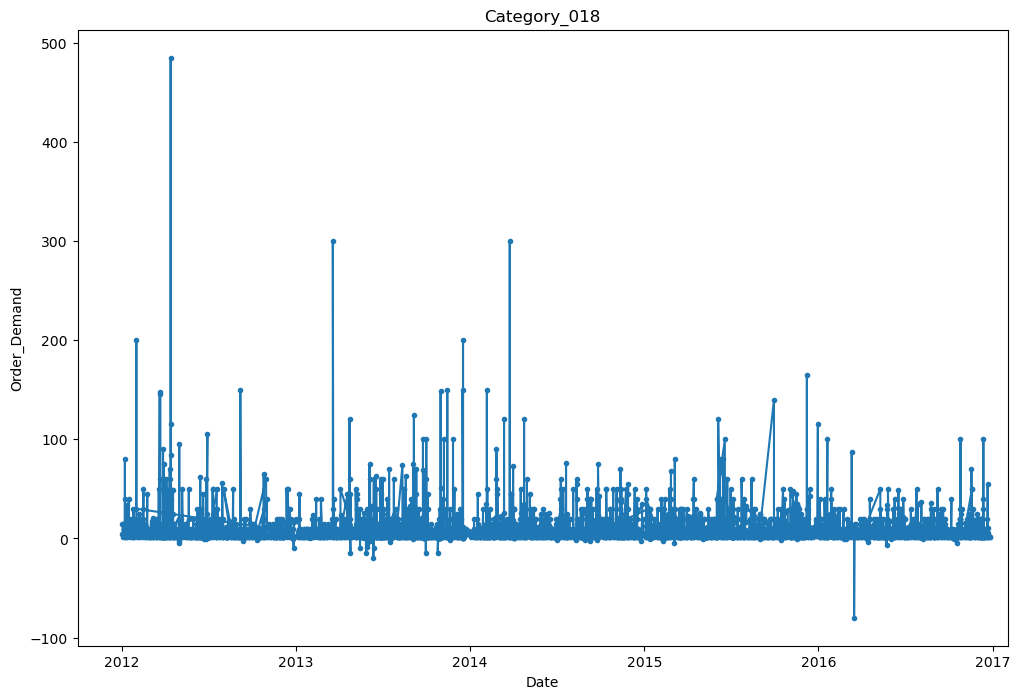

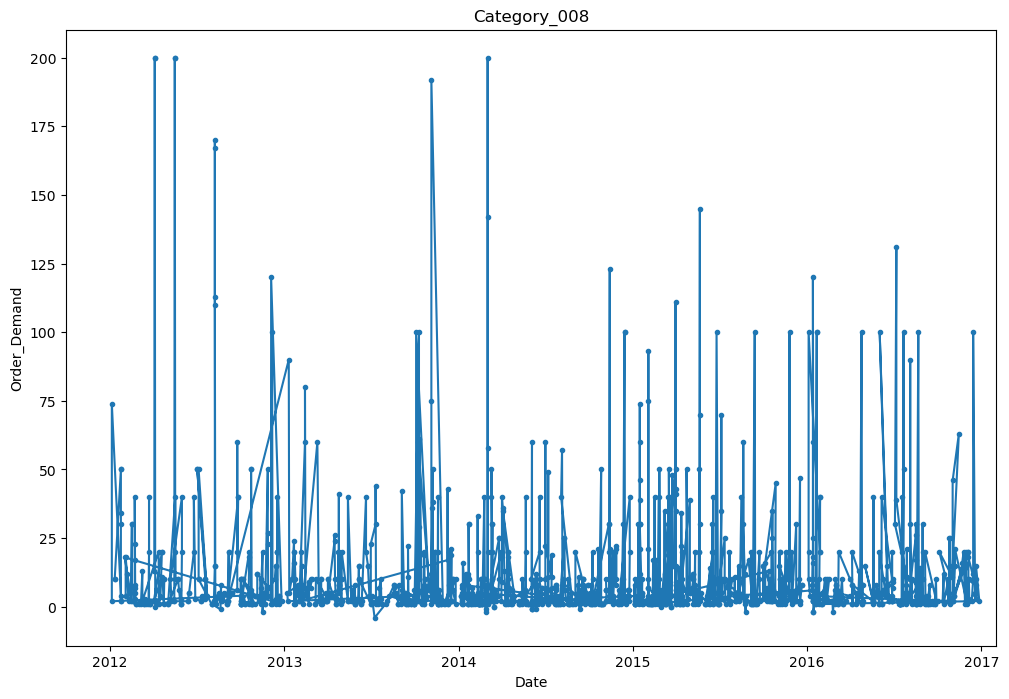

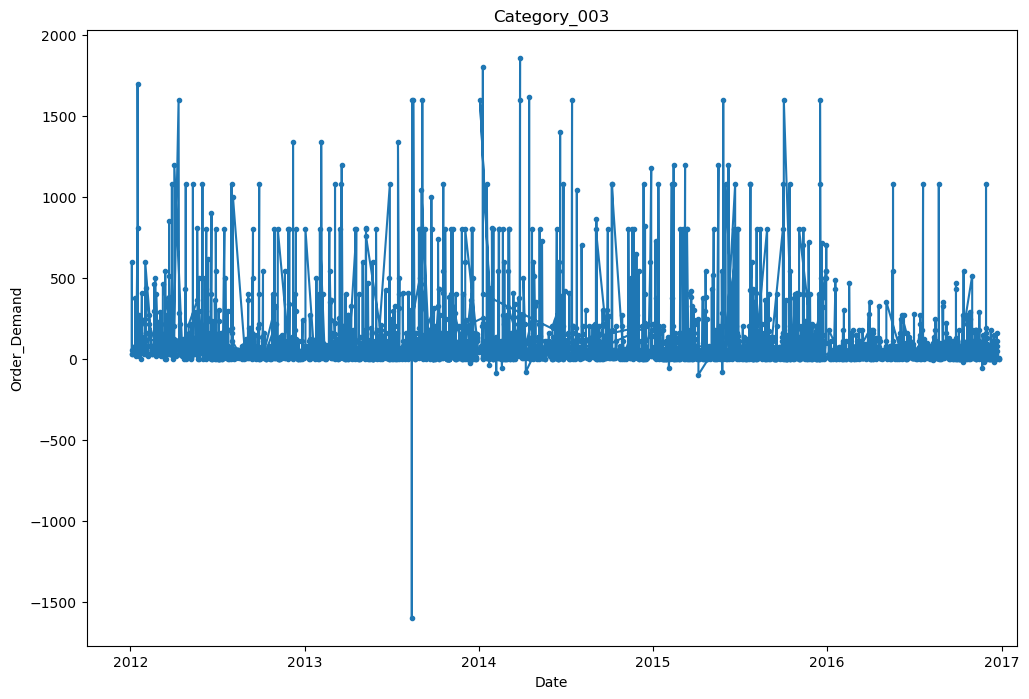

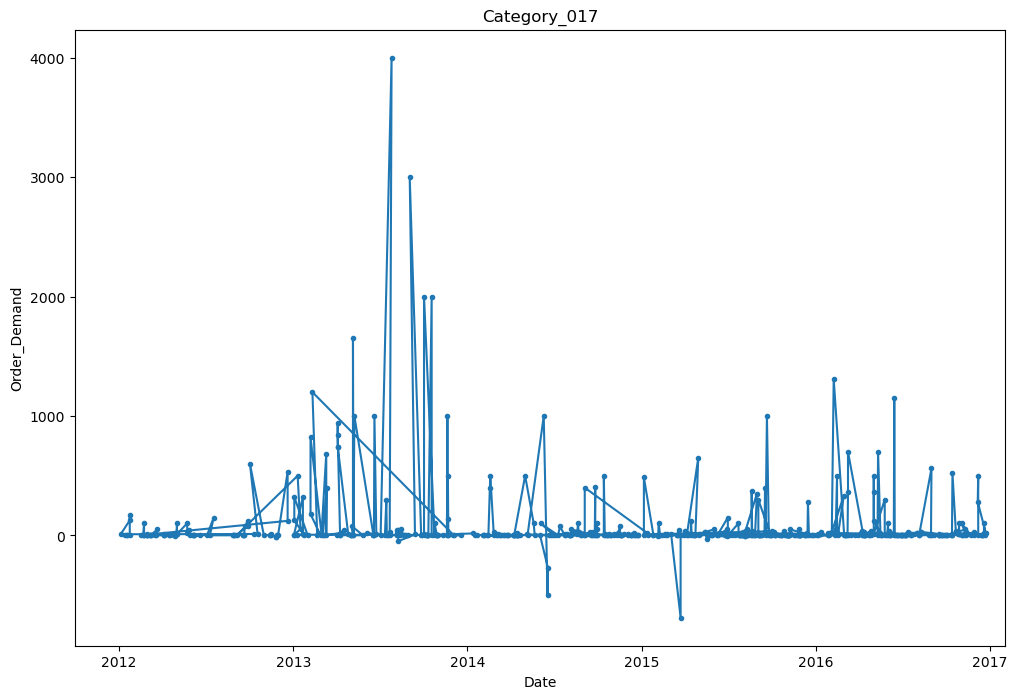

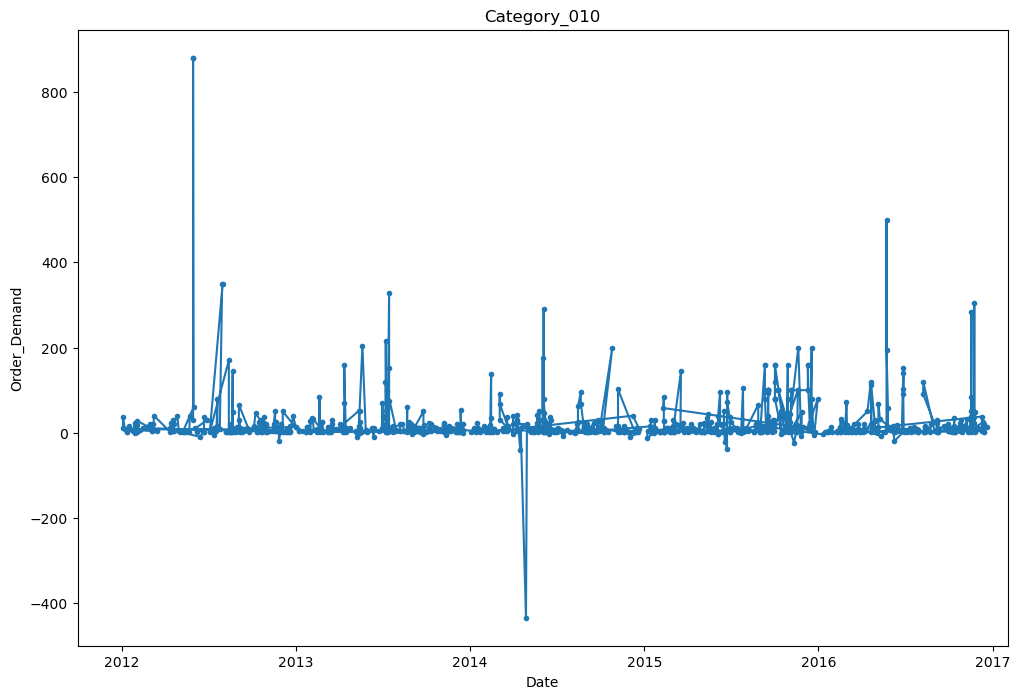

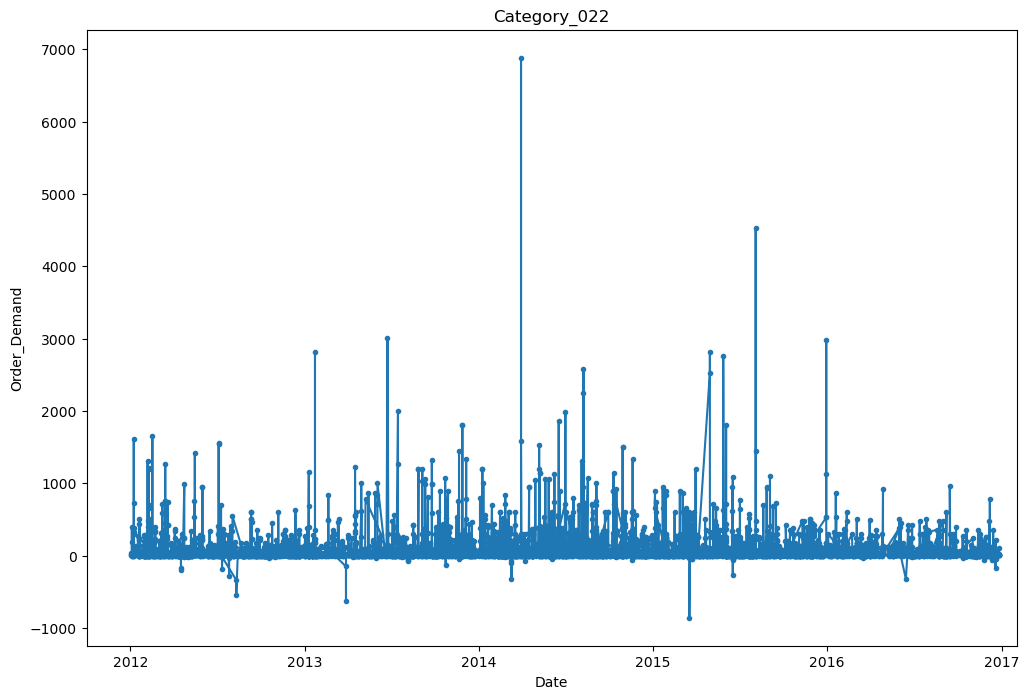

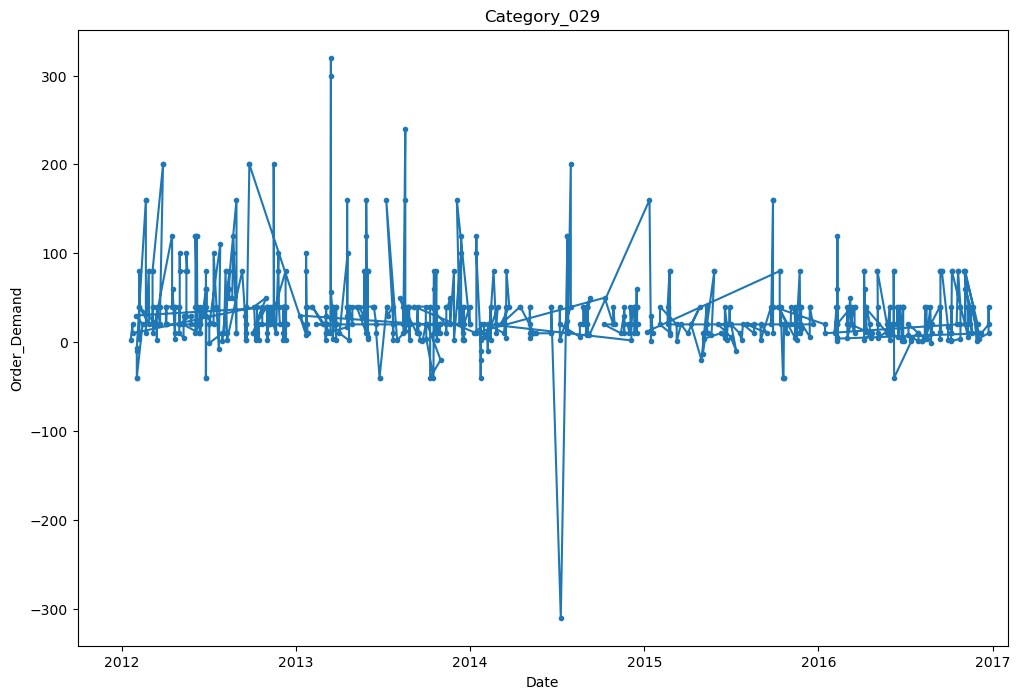

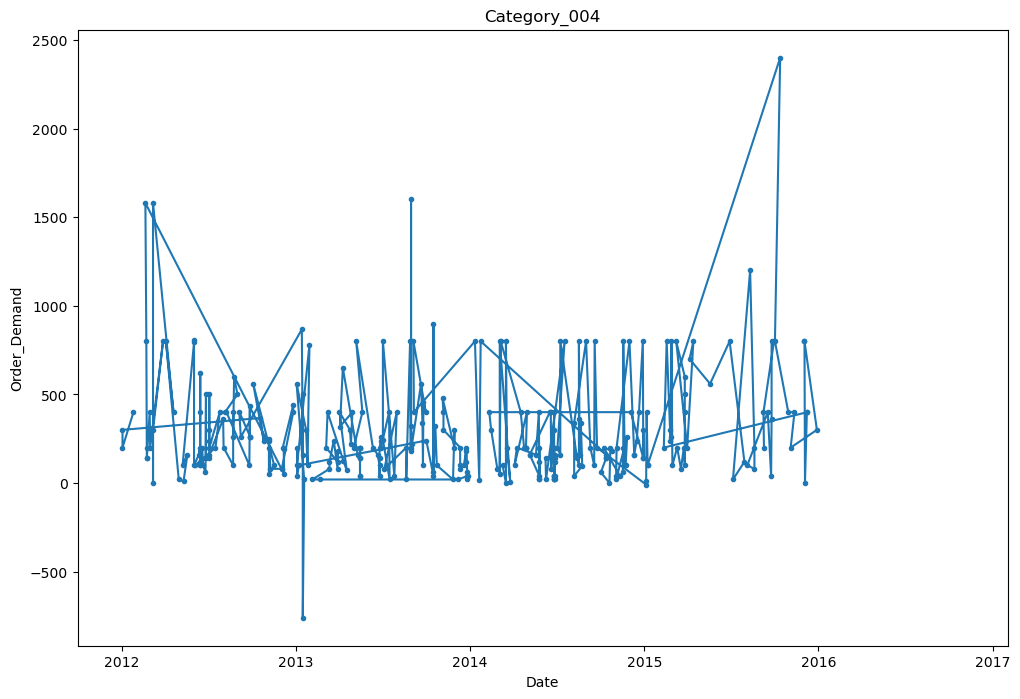

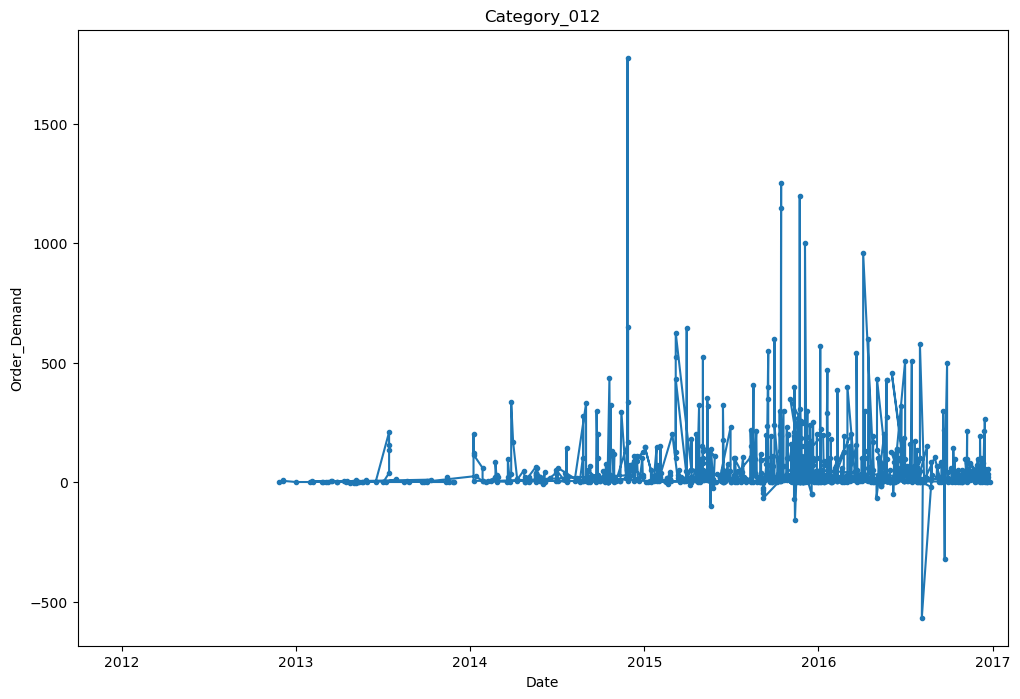

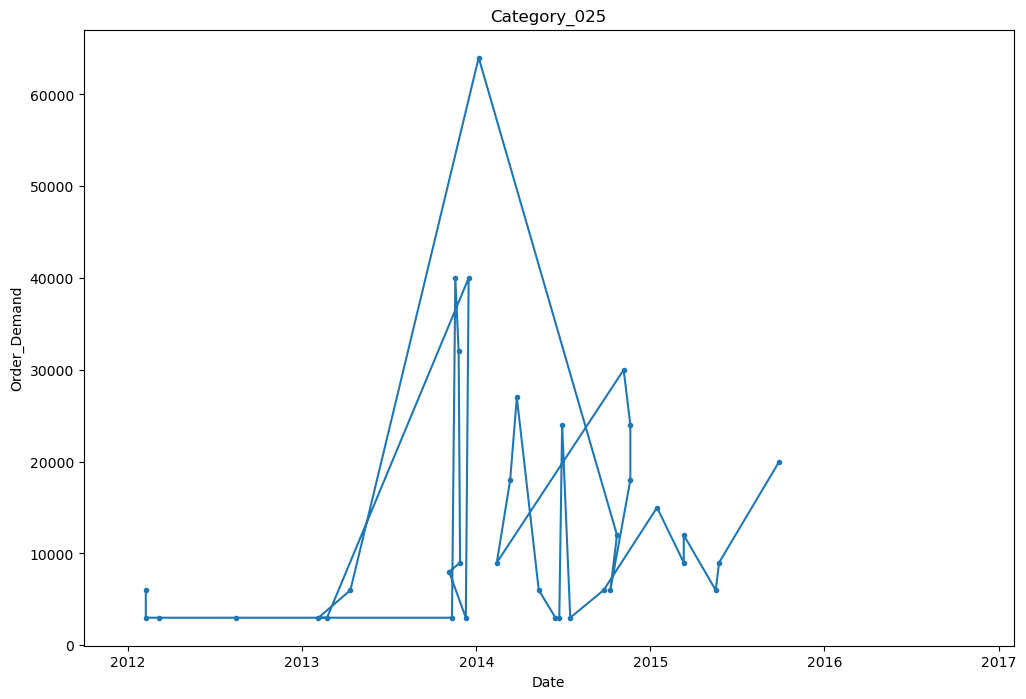

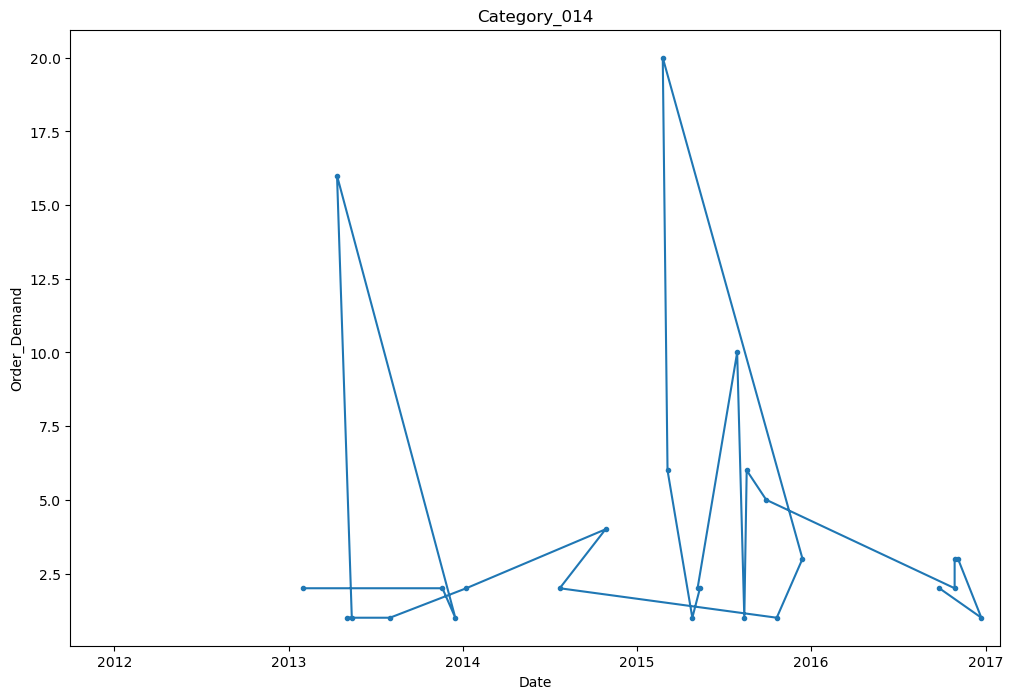

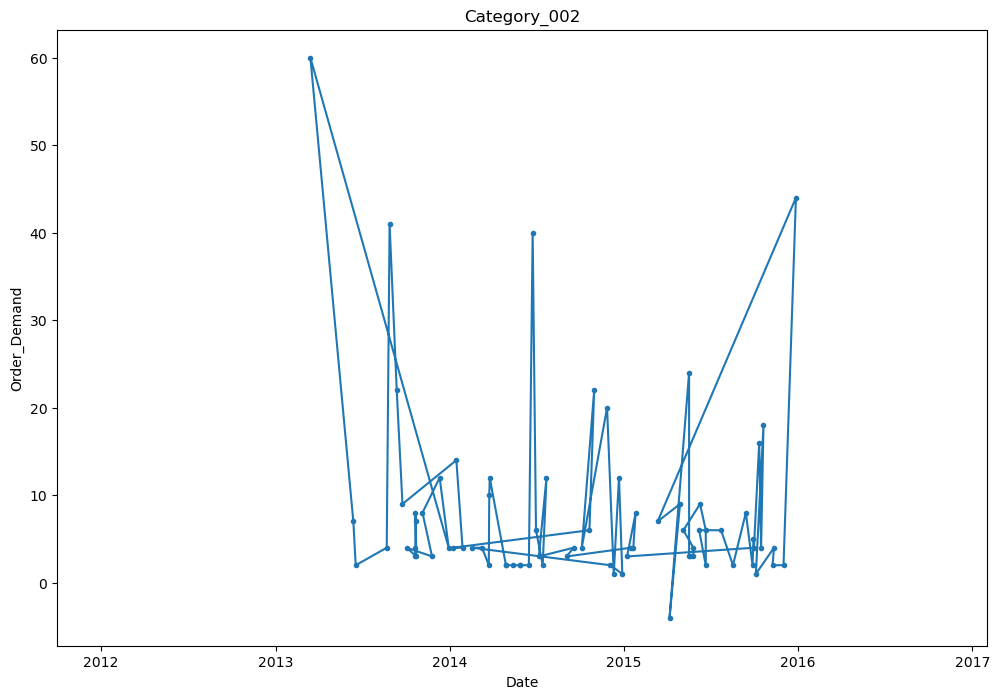

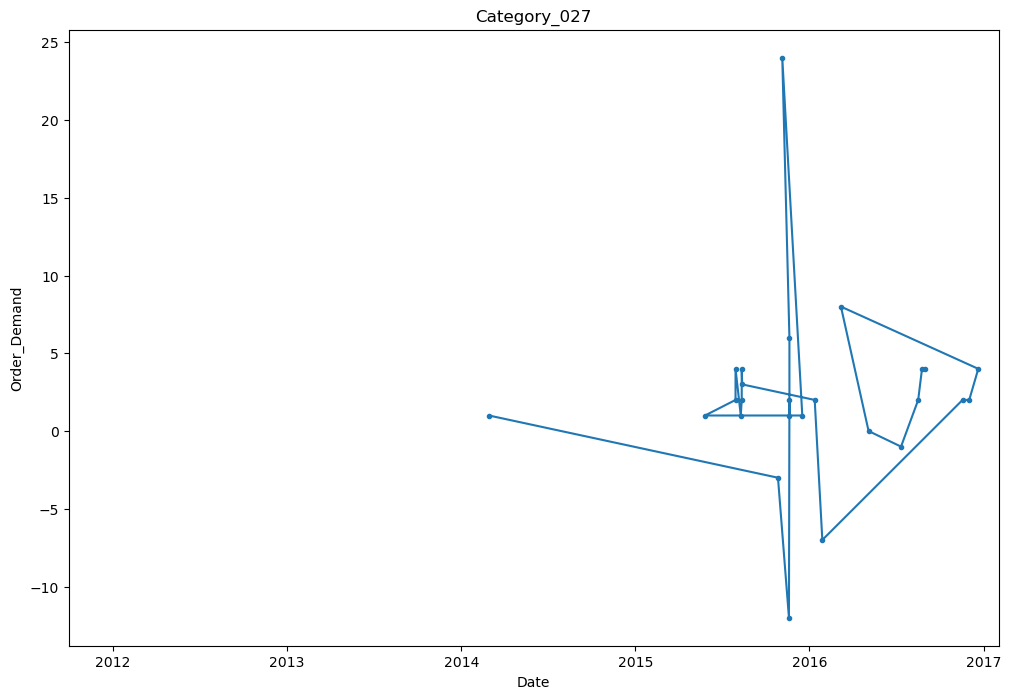

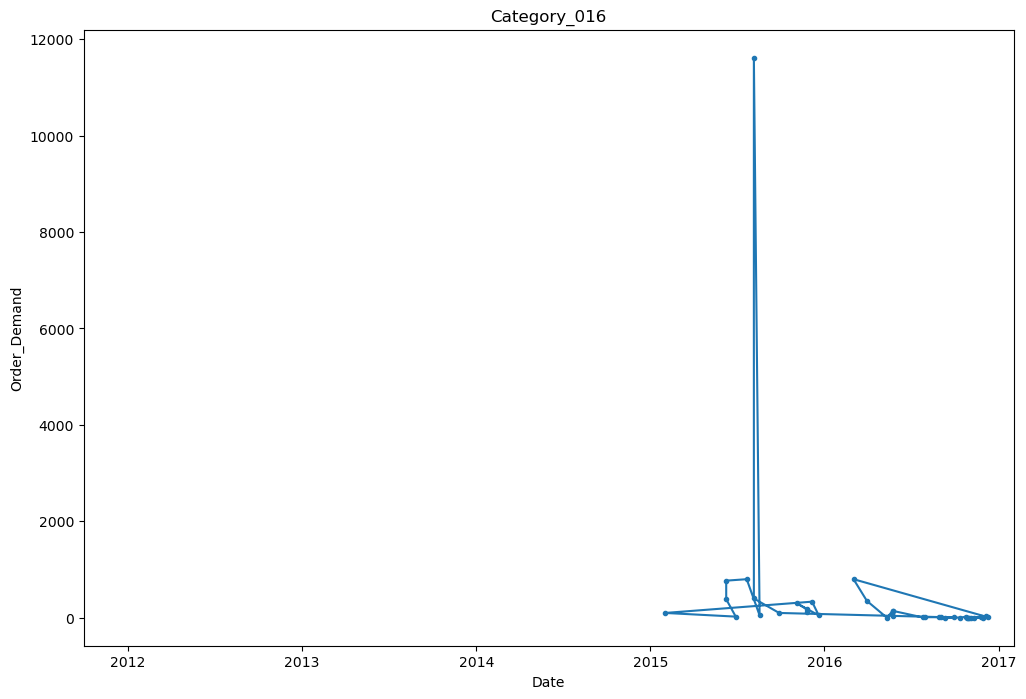

In [24]:
for Prod in df.Product_Category.unique():
    fig = plt.figure(figsize = (12,8))
    ax = plt.axes()
    plt.xlabel("Date")
    plt.ylabel("Order_Demand")
    plt.title(Prod)
    plt.xlim([datetime.date(2011,10,1),datetime.date(2017,2,1)])


    ax.plot(df[(df["Product_Category"] == Prod)]["Date"], 
            df[(df["Product_Category"] == Prod)]["Order_Demand"],
            marker = ".")

Smaller categories seem to show very inconsistent data across the graph. It can also be seen that some categories, like 27 and 16, are newer introudced products, while items like Category 2 are shown to now have no demand are likely discontinued. A low number could indicate specialty products, or maybe some error in entry - without further context, it is difficult to draw meaningful conclusions.

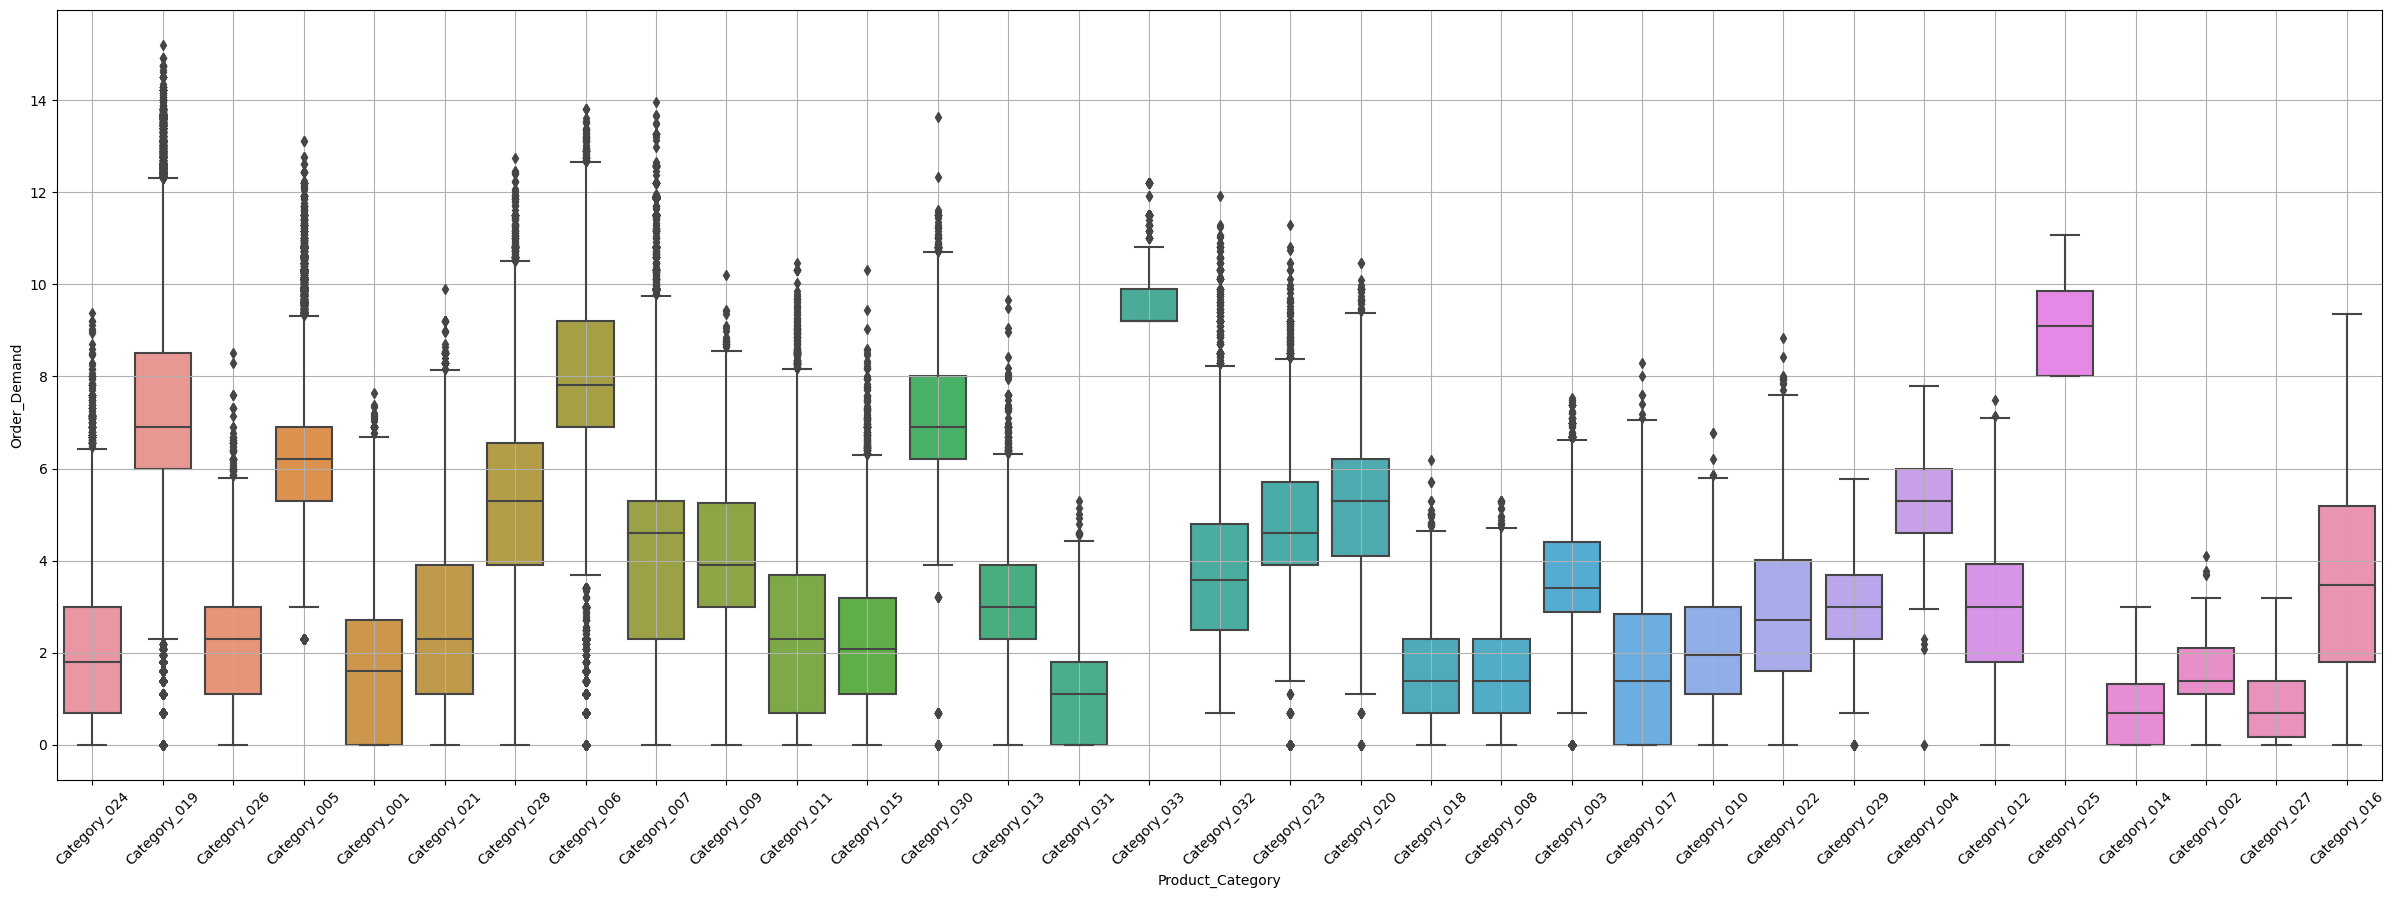

In [25]:
#Plotting Category vs. Log(Order_Demand) to put items on similar scale
plt.figure(figsize = (30,10))
sns.boxplot(df, x = df.Product_Category, y = np.log(df.Order_Demand), showfliers = True)
plt.tick_params(axis='x', rotation=45)
plt.grid()

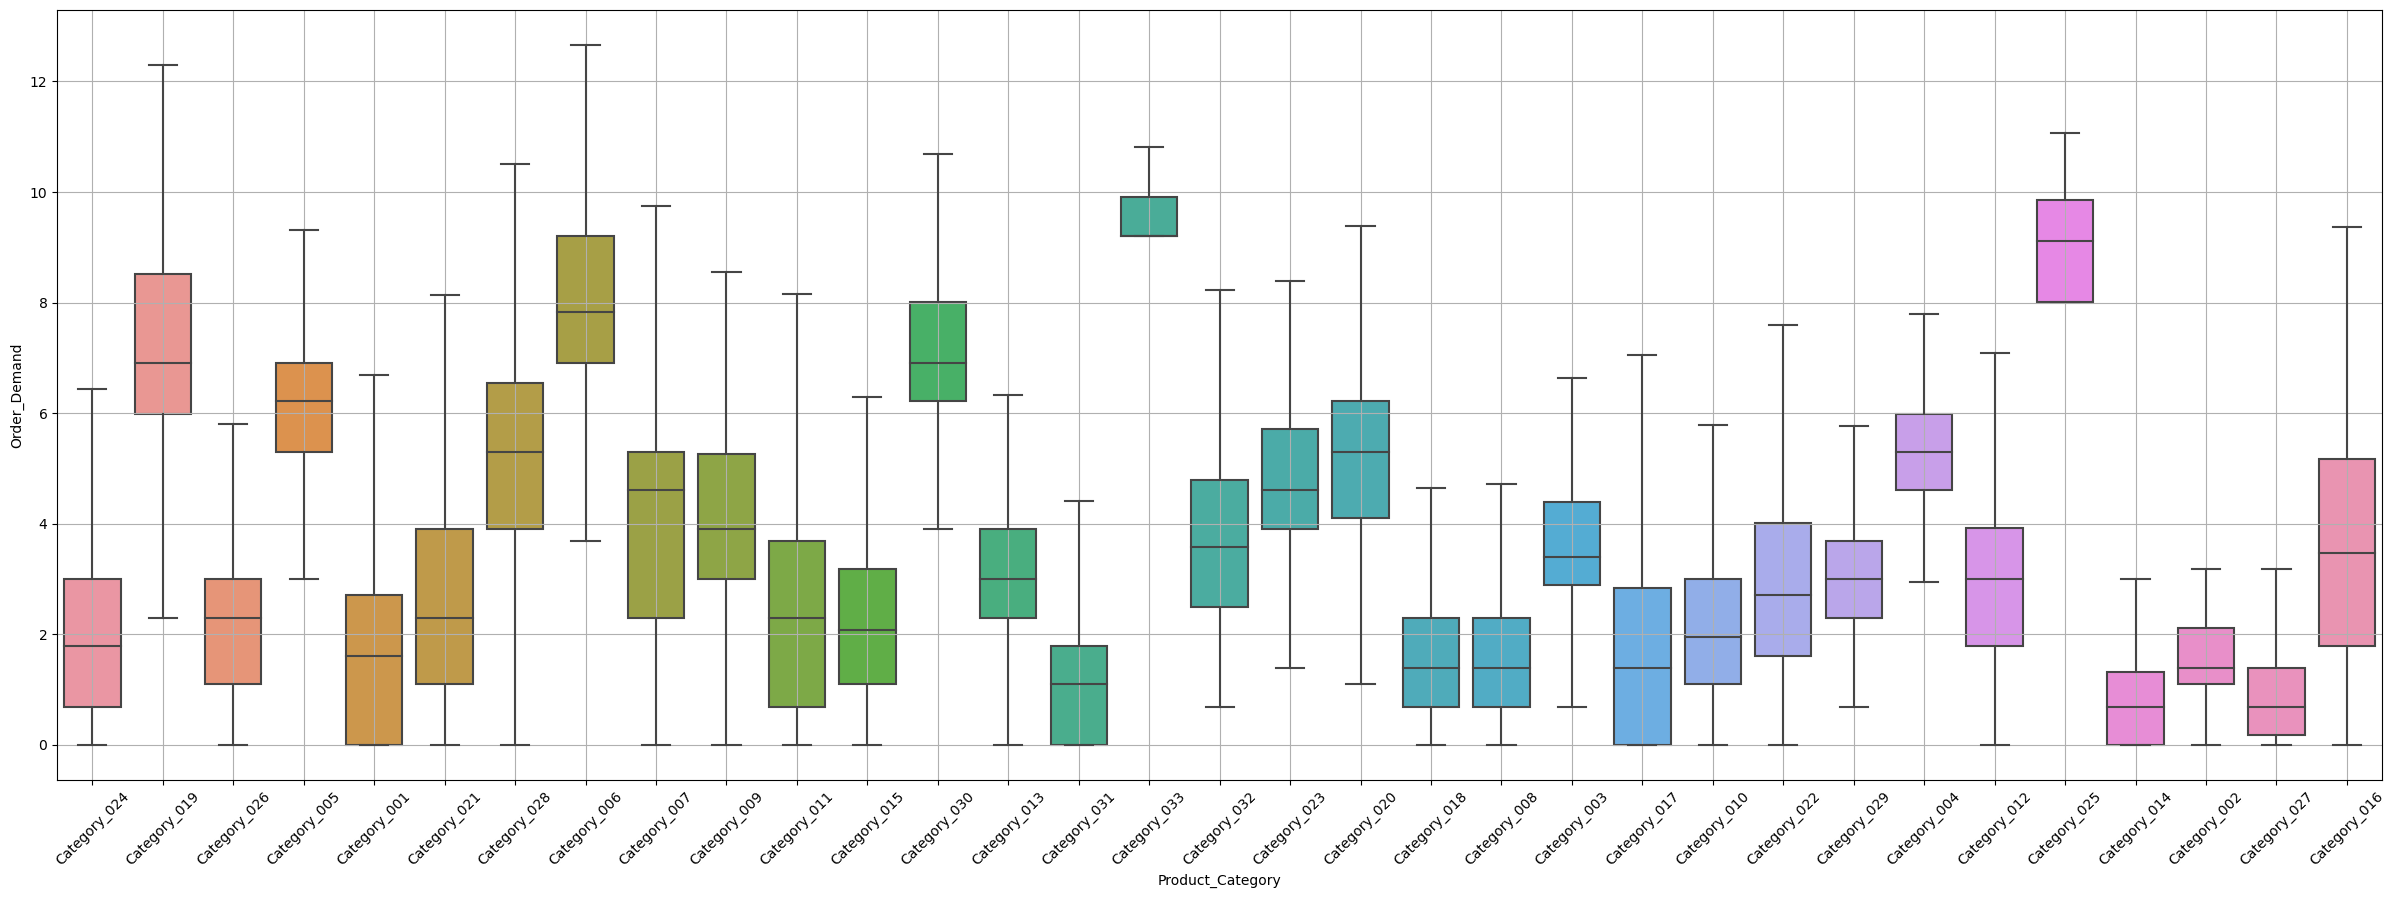

In [26]:
#Plotting Category vs. Log(Order_Demand) to put items on similar scale
plt.figure(figsize = (30,10))
sns.boxplot(df, x = df.Product_Category, y = np.log(df.Order_Demand), showfliers = False)
plt.tick_params(axis='x', rotation=45)
plt.grid()

## Time Series

Will begin with time series of Category_019, as it is the largest category by number of orders demanded.

In [27]:
df19 = df[(df["Product_Category"] == "Category_019")].copy()

In [28]:
df19.describe(include = "all").T

count unique                  top    freq      first  \
Product_Code        470090    534         Product_1359   16935        NaT   
Warehouse           470090      4               Whse_J  369048        NaT   
Product_Category    470090      1         Category_019  470090        NaT   
Date                470090   1579  2013-10-25 00:00:00    1311 2012-01-02   
Order_Demand      470090.0    NaN                  NaN     NaN        NaT   

                       last         mean           std       min    25%  \
Product_Code            NaT          NaN           NaN       NaN    NaN   
Warehouse               NaT          NaN           NaN       NaN    NaN   
Product_Category        NaT          NaN           NaN       NaN    NaN   
Date             2016-12-30          NaN           NaN       NaN    NaN   
Order_Demand            NaT  8962.259503  40921.323719 -999000.0  350.0   

                     50%     75%        max  
Product_Code         NaN     NaN        NaN  
Warehouse            NaN     NaN        NaN  
Product_Category     NaN     NaN        NaN  
Date                 NaN     NaN        NaN  
Order_Demand      1000.0  5000.0  4000000.0

In [29]:
df19 = df19.groupby("Date")["Order_Demand"].sum().reset_index()
df19 = df19.set_index("Date")

In [30]:
df19.head()

Order_Demand
Date                    
2012-01-02        653950
2012-01-03       1499806
2012-01-04        626100
2012-01-05       7458199
2012-01-06       3442875

##### Resampling - a time-based groupby, followed by a reduction method on each of its groups. See exanokes below:

    B         business day frequency
    C         custom business day frequency (experimental)
    D         calendar day frequency
    W         weekly frequency
    ** M         month end frequency
    ** SM        semi-month end frequency (15th and end of month)
    BM        business month end frequency
    CBM       custom business month end frequency
    MS        month start frequency
    SMS       semi-month start frequency (1st and 15th)
    BMS       business month start frequency
    CBMS      custom business month start frequency
    Q         quarter end frequency
    BQ        business quarter endfrequency
    QS        quarter start frequency
    BQS       business quarter start frequency
    A         year end frequency
    BA, BY    business year end frequency
    AS, YS    year start frequency
    BAS, BYS  business year start frequency
    BH        business hour frequency
    H         hourly frequency
    T, min    minutely frequency
    S         secondly frequency
    L, ms     milliseconds
    U, us     microseconds
    N         nanoseconds

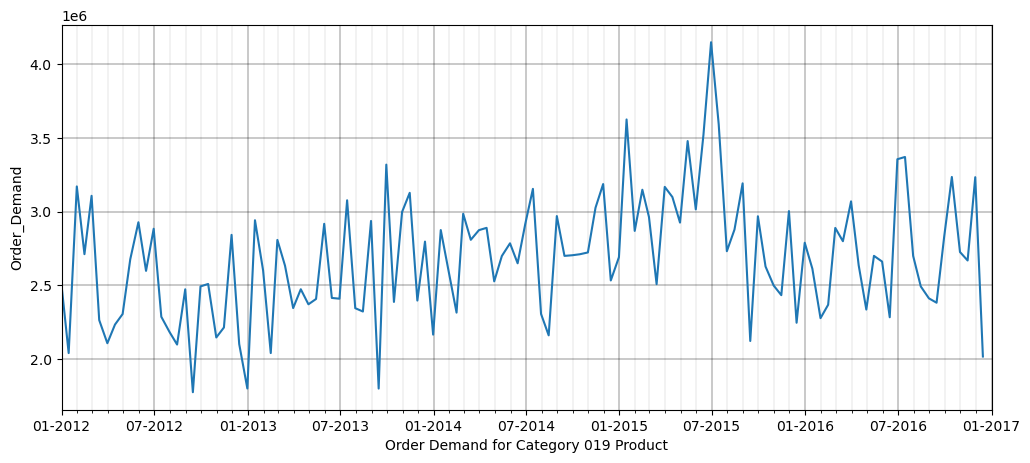

In [31]:
#Pulling sample information based on Semi-Month End Frequency
TrendOrderSM = df19["Order_Demand"].resample("SM").mean()

#Import time information to improve plotting
import matplotlib.dates as mdates

#Plotting Data and fixing axes
fig = plt.figure(figsize = (12,5))
ax = plt.axes()

plt.xlabel("Date")
ax.set_xlim([datetime.date(2012, 1, 1), datetime.date(2017, 1, 1)])
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
ax.grid(visible=True, which='major', axis = 'x', color='black', linewidth=0.3)
ax.grid(visible=True, which='minor', axis = 'x', color='black', linewidth=0.075)

plt.ylabel("Order_Demand")
ax.grid(visible=True, which='major', axis = 'y', color='black', linewidth=0.3)

plt.xlabel("Order Demand for Category 019 Product")

ax.plot(TrendOrderSM)

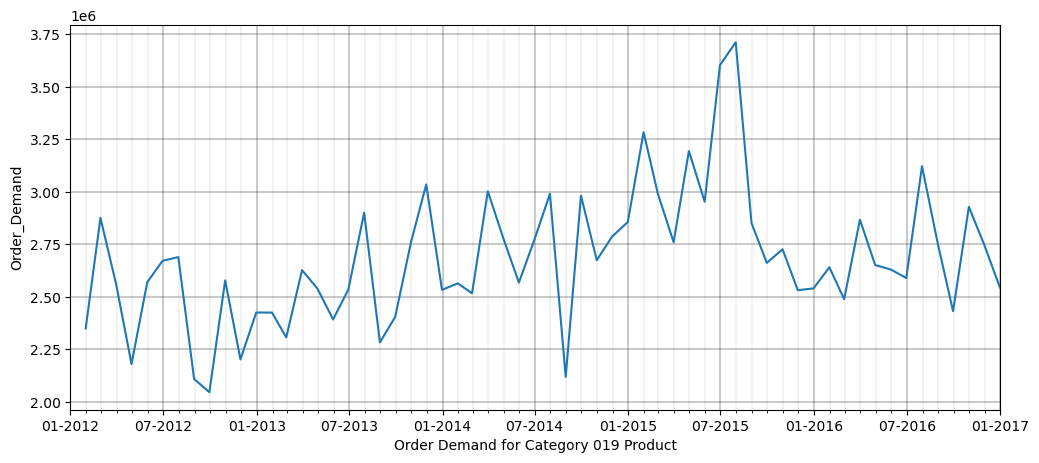

In [32]:
#Pulling sample information based on Month End Frequency
TrendOrderM = df19["Order_Demand"].resample("M").mean()

#Plotting Data and fixing axes
fig = plt.figure(figsize = (12,5))
ax = plt.axes()

plt.xlabel("Date")
ax.set_xlim([datetime.date(2012, 1, 1), datetime.date(2017, 1, 1)])
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
ax.grid(visible=True, which='major', axis = 'x', color='black', linewidth=0.3)
ax.grid(visible=True, which='minor', axis = 'x', color='black', linewidth=0.075)

plt.ylabel("Order_Demand")
ax.grid(visible=True, which='major', axis = 'y', color='black', linewidth=0.3)

plt.xlabel("Order Demand for Category 019 Product")

ax.plot(TrendOrderM)

### Using Month-End Reduction Method moving forward.

We can use the **Augmented Dickey-Fuller (ADF) Test** to verify if the series is stationary or not.
The null and alternate hypotheses for the ADF Test are defined as: 
- **Null hypothesis:** The Time Series is non-stationary
- **Alternative hypothesis:** The Time Series is stationary

In [33]:
# Define a function to use adfuller test
def adfuller(data):
    
  #Importing adfuller using statsmodels
    from statsmodels.tsa.stattools import adfuller
    
    print('Dickey-Fuller Test: ')
    
    adftest = adfuller(data)
    
    adfoutput = pd.Series(adftest[0:4], index = ['Test Statistic', 'p-value', 'Lags Used', 'No. of Observations'])
    
    for key, value in adftest[4].items():
        adfoutput['Critical Value (%s)'%key] = value
    
    print(adfoutput)

adfuller(TrendOrderM)

Dickey-Fuller Test: 
Test Statistic          -5.125913
p-value                  0.000012
Lags Used                0.000000
No. of Observations     59.000000
Critical Value (1%)     -3.546395
Critical Value (5%)     -2.911939
Critical Value (10%)    -2.593652
dtype: float64


In this case, we can see thatt the p-value is < 0.05, so we can **reject the null hypothesis** and conclude that the **data is stationary**.

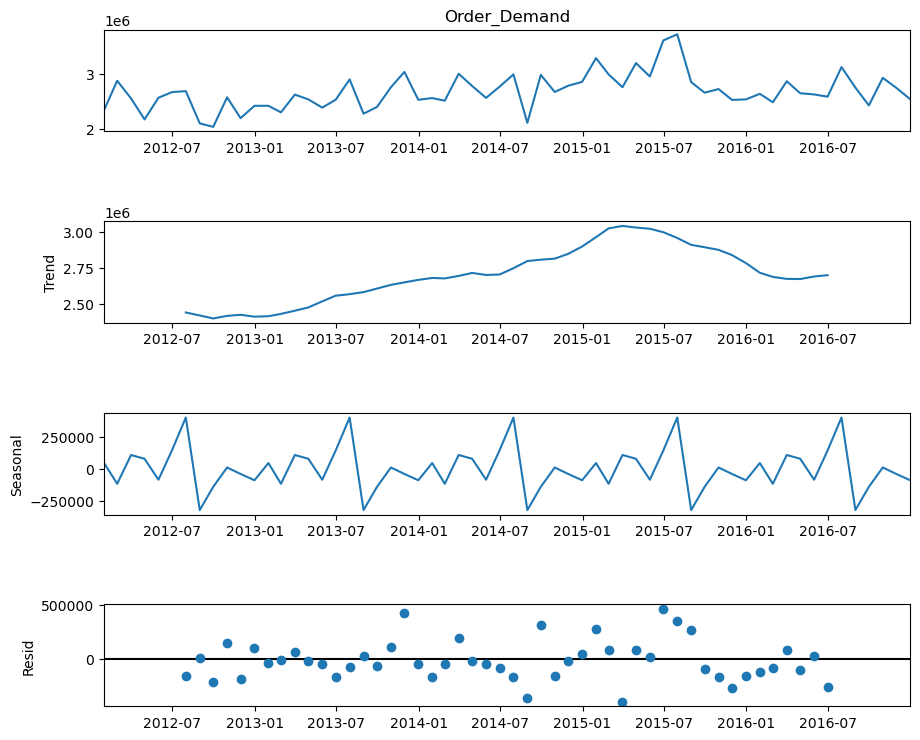

In [34]:
#Time Series Decomposition. 
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(TrendOrderM, model='additive')
fig = decomposition.plot()
fig.set_figwidth(10)
fig.set_figheight(8)

In [35]:
decomposition.resid.mean()

-11414.011995163048

In an additive plot, the mean of the residuals should approach 0. In this case, the mean is quite far off, indicating that this may not be the correct decomposition model.

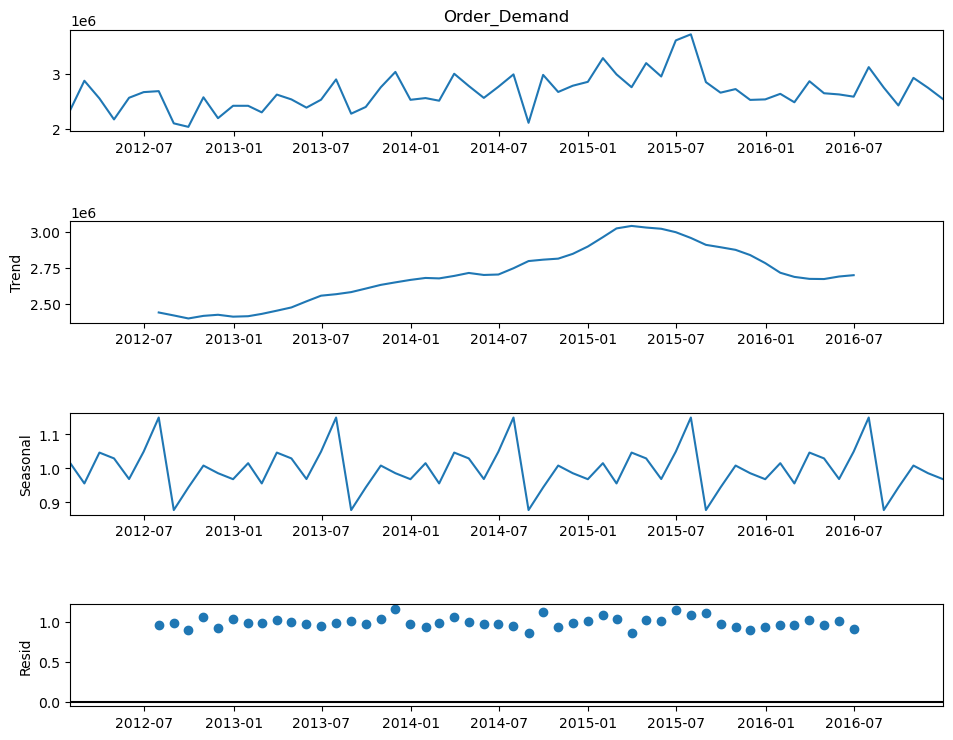

In [36]:
decomposition2 = sm.tsa.seasonal_decompose(TrendOrderM, model='multiplicative')
fig = decomposition2.plot()
fig.set_figwidth(10)
fig.set_figheight(8)

In [37]:
decomposition2.resid.mean()

0.9949293487412033

In a multiplicative plot, the mean of residuals should focus around 1 as multiplying by 1 does not change the value.

### Decomposition
All time series data can be broken down into four core components: 
 * **Level** - The average value 
 * **Trend** - A trend (i.e. an increasing/ decreasing mean)
 * **Seasonality** - The repeating short-term cycle in the series(i.e. a repeating cyclical pattern)
 * **Noise** - A residual (random noise). 
 
Trends and seasonality are not always present in time dependent data. The residual is what’s left over after trends and seasonality are removed. Time series models assume that the data is stationary and only the residual component satisfies the conditions for stationarity.

#### Additive
y(t) = Level + Trend + Seasonality + Noise
 * An additive model is linear where changes over time are consistently made by the same amount.
 * A linear trend is a straight line.
 * A linear seasonality has the same frequency (width of cycles) and amplitude (height of cycles).

#### Multiplicative
y(t) = Level * Trend * Seasonality * Noise
 * A multiplicative model is nonlinear, such as quadratic or exponential. Changes increase or decrease over time.
 * A nonlinear trend is a curved line.
 * A non-linear seasonality has an increasing or decreasing frequency and/or amplitude over time.

##### References: 
 * https://towardsdatascience.com/time-series-decomposition-and-statsmodels-parameters-69e54d035453
 * https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/

## Model Building

<Figure size 1600x800 with 0 Axes>

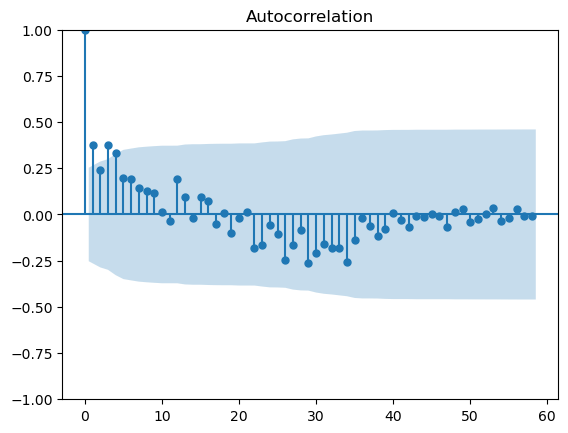

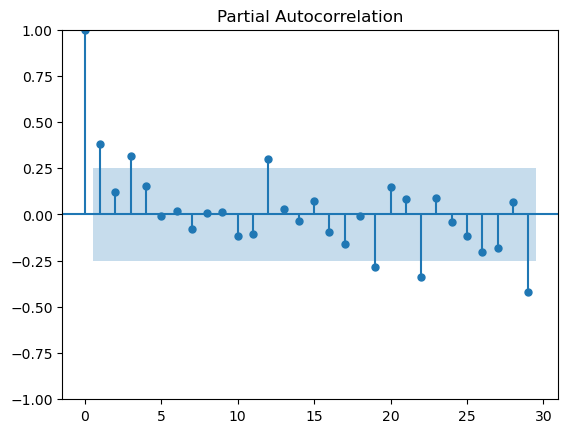

In [38]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize = (16, 8))

plot_acf(TrendOrderM, lags = 58) 

plt.show()

plot_pacf(TrendOrderM, lags = 29) 

plt.show()

We see that the farthest extended point in the ACF is 3, so we will use this for the number of lags in the MA model
We see that the farthest extended point in the PACF is 3, so we will use this for the number of lags in the AR model.


### AR - Auto-Regressive
$X_{t}$ depends on the past values of the process

AR Models are Stationary

AR Models always have a decaying exponential autocovariance. 
 * i.e as the steps between points become larger, the values become less and less correlated.
---
##### Model
$$ X_{t} = \sum_{i=1}^{p} a_{i}X_{t-1} + w_{t}$$

 * $X_t$ is the predicted value
 * $w_t$ is white noise
 * $a_{i}X_{t-1}$ is some linear combination of previous data up to level $p$
 * $p$ is memory (hyperparameter).
   * Example: If data is on monthly basis and $p$=10, data will look at the parameters from the past 10 months

##### Autocovariance
$$R_{X}(\tau) = \sum_{i=1}^{p} a_{i}R_{x}(\tau - i) + \sigma^{2}\delta(\tau)$$

 * $R_{X}(\tau)$ is the autocovariance as a function of $\tau$
 * $\tau$ is the lag, or step size between points evaluated
 * $\delta(\tau)$ is a function where:
   * $\delta(\tau) = 1$ at $\tau =0$
   * $\delta(\tau) = 0$ at $\tau =$ any other value

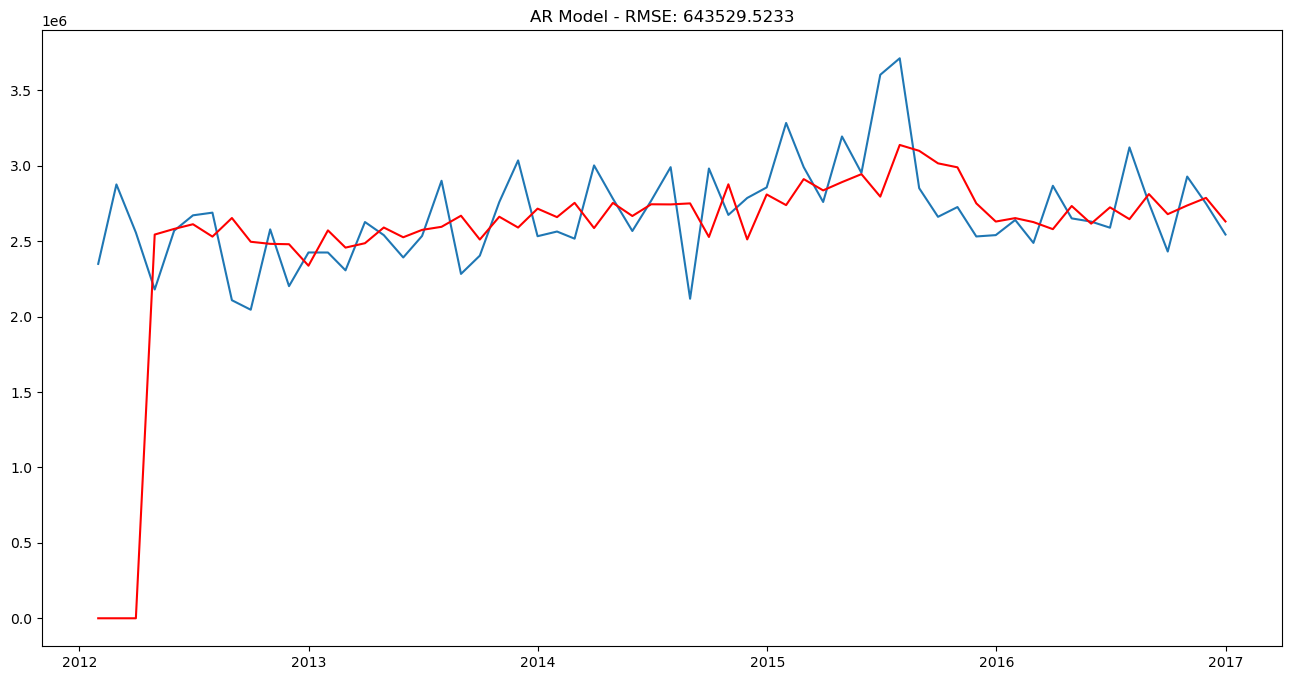

In [39]:
# Importing AutoReg function to apply AR model
from statsmodels.tsa.ar_model import AutoReg

# To calculate the MSE or RMSE
from sklearn.metrics import mean_squared_error
plt.figure(figsize = (16, 8))

# Using number of lags as 7
model_AR = AutoReg(TrendOrderM, lags = 3)

results_AR = model_AR.fit()

plt.plot(TrendOrderM)

predict = results_AR.predict(start = 0, end = len(TrendOrderM) - 1)

# Converting NaN values to 0
predict = predict.fillna(0)

plt.plot(predict, color = 'red')

# Calculating rmse
plt.title('AR Model - RMSE: %.4f'% mean_squared_error(predict, TrendOrderM, squared = False))

plt.show()

In [40]:
# The Akaike Information Criterion (AIC) is an estimator of the relative quality of statistical models 
# for a given set of data. 
# The best-fit model according to AIC is the one that explains the greatest amount of variation 
# using the fewest possible independent variables.
  # Large AIC: Model fits very well using a lot of features.
  # Small AIC: Model fits similar fit but using lesser features. 
    # Hence LOWER THE AIC, the better it is.
results_AR.aic

1602.358670796815

### MA - Moving Average
$X_{t}$ depends on the past values of the noise

MA Models are Stationary

MA Models have an autocovariance defined only within their applicable window of lag
 * "Finite Support"
 * if $\tau$ =4 and $q$=3:
    * $j=0$, $b_{0 - 4} = b_{-4} = 0$
    * $j=1$, $b_{1 - 4} = b_{-3} = 0$
    * $j=2$, $b_{2 - 4} = b_{-2} = 0$
    * $j=3$, $b_{3 - 4} = b_{-1} = 0$
 * The only coefficients that exist are $b_{0},b_{1},b_{2},b_{3}$ but $q < \tau$ prevents us from reaching a threshold with non 0 values
   * Memory cannot be less than the step size
---
##### Model
$$ X_{t} = \sum_{j=0}^{q} b_{j}w_{t-j}$$
 * $X_t$ is the predicted value
 * $b_{i}w_{t-i}$ is a constant multiplied by the previous noise up to level $q$
 * $q$ is memory (hyperparameter).
   * Example: If data is on monthly basis and $q$=10, data will look at the noise from the past 10 months

##### Autocovariance
$$R_{X}(\tau) = \sigma^{2} \sum_{j=0}^{q} b_{j}b_{j-\tau}$$


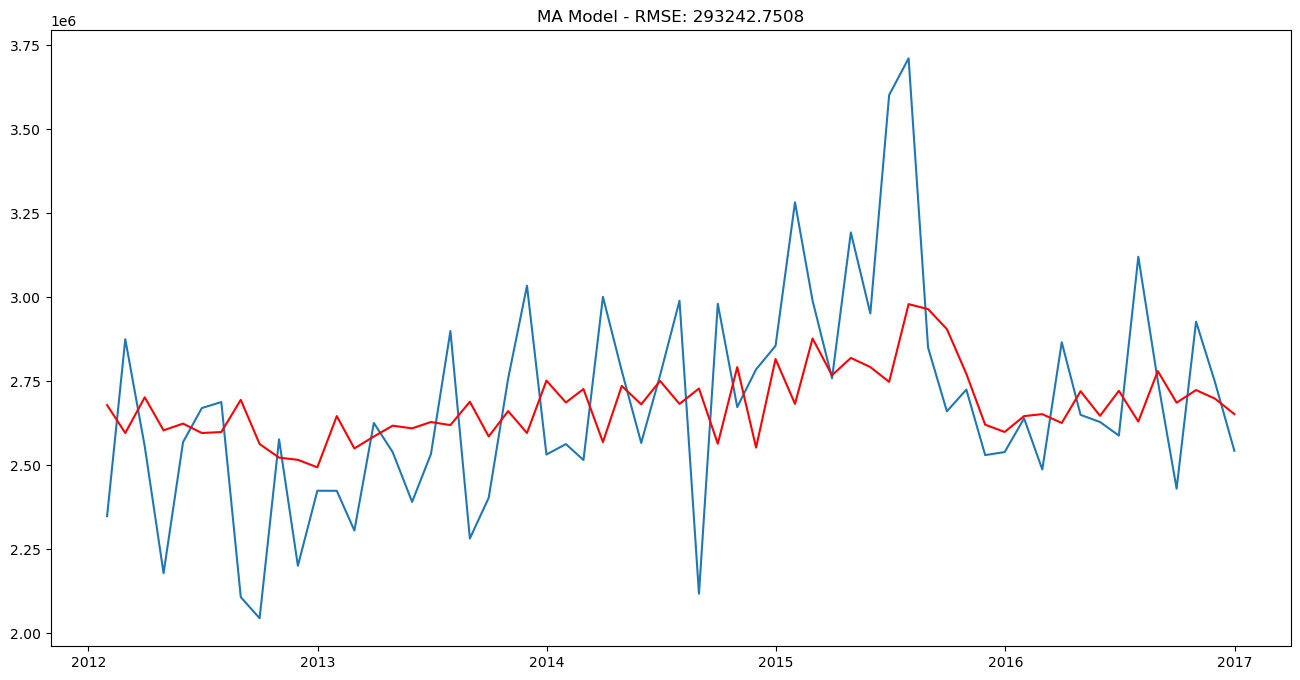

In [41]:
#Using ARIMA model with p,d = 0 and q = 3
from statsmodels.tsa.arima.model import ARIMA

plt.figure(figsize = (16, 8))

# Using p=0, d = 0, q = 12
model_MA = ARIMA(TrendOrderM, order = (0, 0, 3))

results_MA = model_MA.fit()

plt.plot(TrendOrderM)

plt.plot(results_MA.fittedvalues, color = 'red')

plt.title('MA Model - RMSE: %.4f'% mean_squared_error(results_MA.fittedvalues, TrendOrderM, squared = False))

plt.show()

In [42]:
results_MA.aic

1690.9630011076533

This model returns a higher AIC value with a better RMSE value. Still shows a difficult time representing some of the seasonality in the trend.

### ARMA - Auto-Regressive Moving Average
$X_{t}$ depends on both the past values of the process and the noise

ARMA Models are Stationary

ARMA Models always have a decaying exponential autocovariance due to the AR contribution.

---
##### Model
$$ X_{t}=\sum_{i=1}^{p}a_{i}X_{t-1}+\sum_{j=0}^{q}b_{j}w_{t-j}$$


C:\Users\lglay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


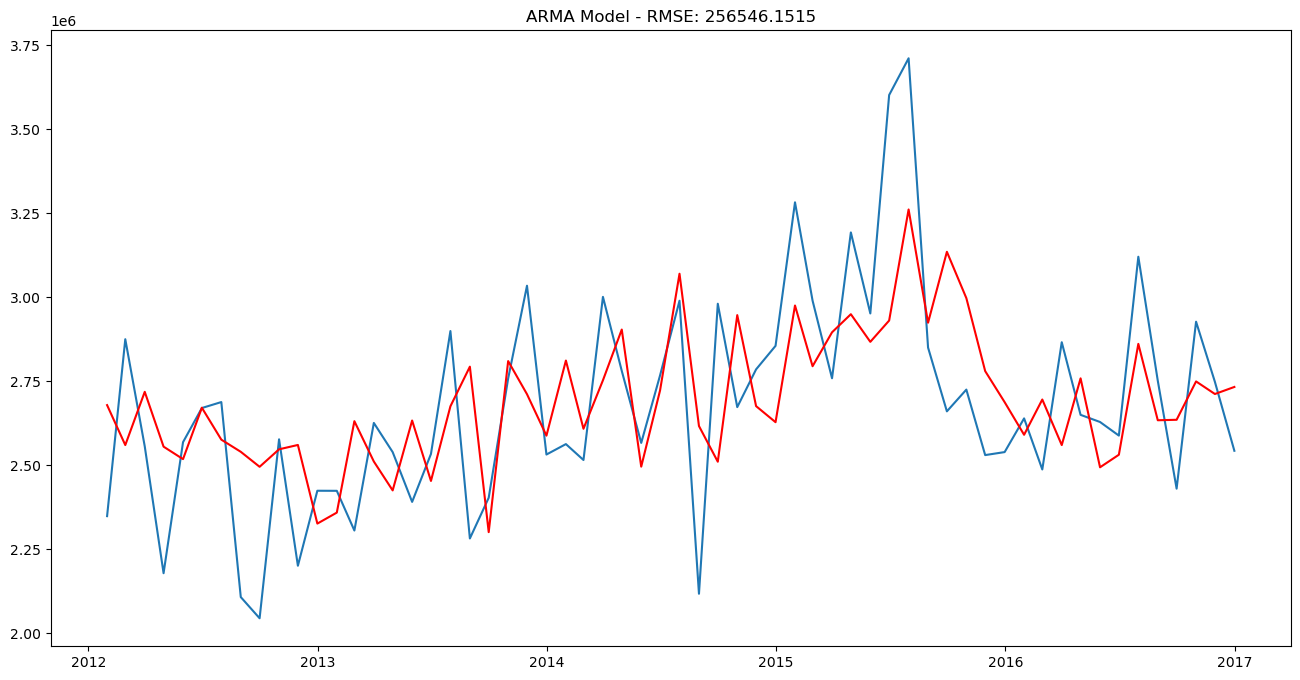

In [43]:
#Using ARIMA model with p=12,d = 0 and q = 3

plt.figure(figsize = (16, 8))

# Using p=12, d = 0, q = 12
model_ARMA = ARIMA(TrendOrderM, order = (12, 0, 3))

results_ARMA = model_ARMA.fit()

plt.plot(TrendOrderM)

plt.plot(results_ARMA.fittedvalues, color = 'red')

plt.title('ARMA Model - RMSE: %.4f'% mean_squared_error(results_ARMA.fittedvalues, TrendOrderM, squared = False))

plt.show()

In [44]:
results_ARMA.aic

1699.7355962463482

The ARMA model has been the best mix of RMSE and aic performance so far.

### ARIMA - Auto-Regressive Integrated Moving Average 
The ARMA consists of mainly two components, the autoregressive and moving average; the ARIMA consists of an integrated moving average of autoregressive time series.  

ARIMA model is useful in the cases where the time series is non-stationary. And the differencing is required to make the time series stationary. 

In our case, the ADF Test showed the data to be stationary, so differencing should not be required. We will still plot a 1st and 2nd Order Differencing below to observe how it affects the data. 

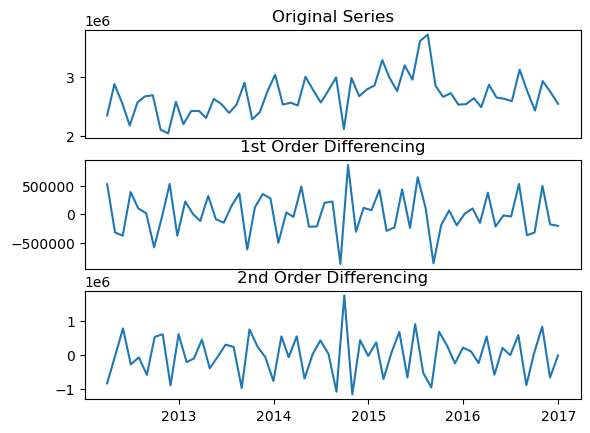

In [45]:
#Checking the effects of differencing on the model
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(TrendOrderM); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(TrendOrderM.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(TrendOrderM.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

Do differentiate the model, we will test to see how 1st Order Differencing affects the AIC and RMSE of the model:

Since we are testing d = 1 in the ARIMA model, it will result in double differencing of the TrendOrderM series. So, we need double shifted series in order to calculate the RMSE of the model.

In [46]:
# Getting double differenced series
TrendOrderM2 = TrendOrderM - TrendOrderM.shift(periods = 2)

TrendOrderM.dropna(inplace = True)

C:\Users\lglay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


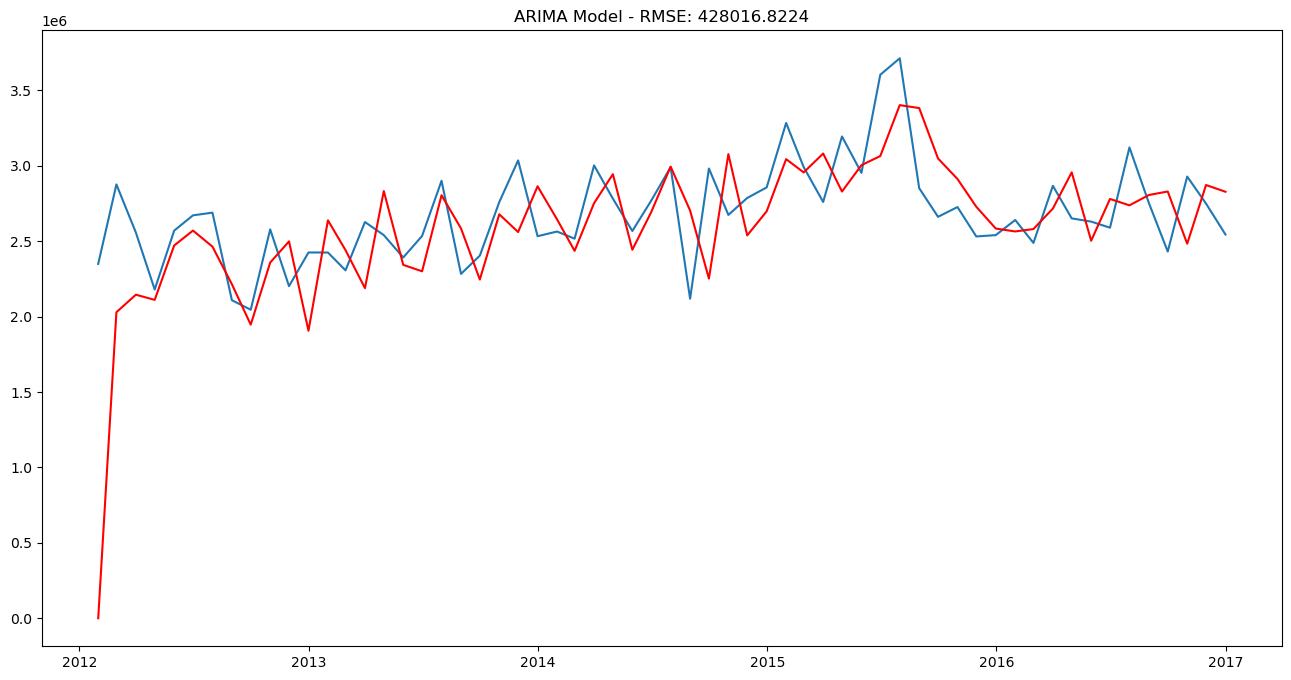

In [47]:
plt.figure(figsize = (16, 8))

# Using p = 12, d = 1, q = 3
model_ARIMA = ARIMA(TrendOrderM, order = (12, 1, 3))

results_ARIMA = model_ARIMA.fit()

plt.plot(TrendOrderM)

plt.plot(results_ARIMA.fittedvalues, color = 'red')

plt.title('ARIMA Model - RMSE: %.4f'% mean_squared_error(results_ARIMA.fittedvalues, TrendOrderM, 
                                                         squared = False))

plt.show()

In [48]:
results_ARIMA.aic

1689.3908608018621

### SARIMAX - Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors
Based on three terms p,d,q:
 * p is the number of autoregressive terms
     * From AR
 * d is the number of non-seasonal differences needed for stationarity
 * q is the number of lagged forecast errors in the prediction equation
     * From MA 
     
A separate Seasonal P,D,Q,s are also estimated.
 * P is the number of autoregressive terms
     * From AR
 * D is the number of differences needed for stationarity
 * Q is the number of lagged forecast errors in the prediction equation
     * From MA 
 * s is an integer giving the periodicity (number of periods in season)
     * Often it is 4 for quarterly data or 12 for monthly data. 

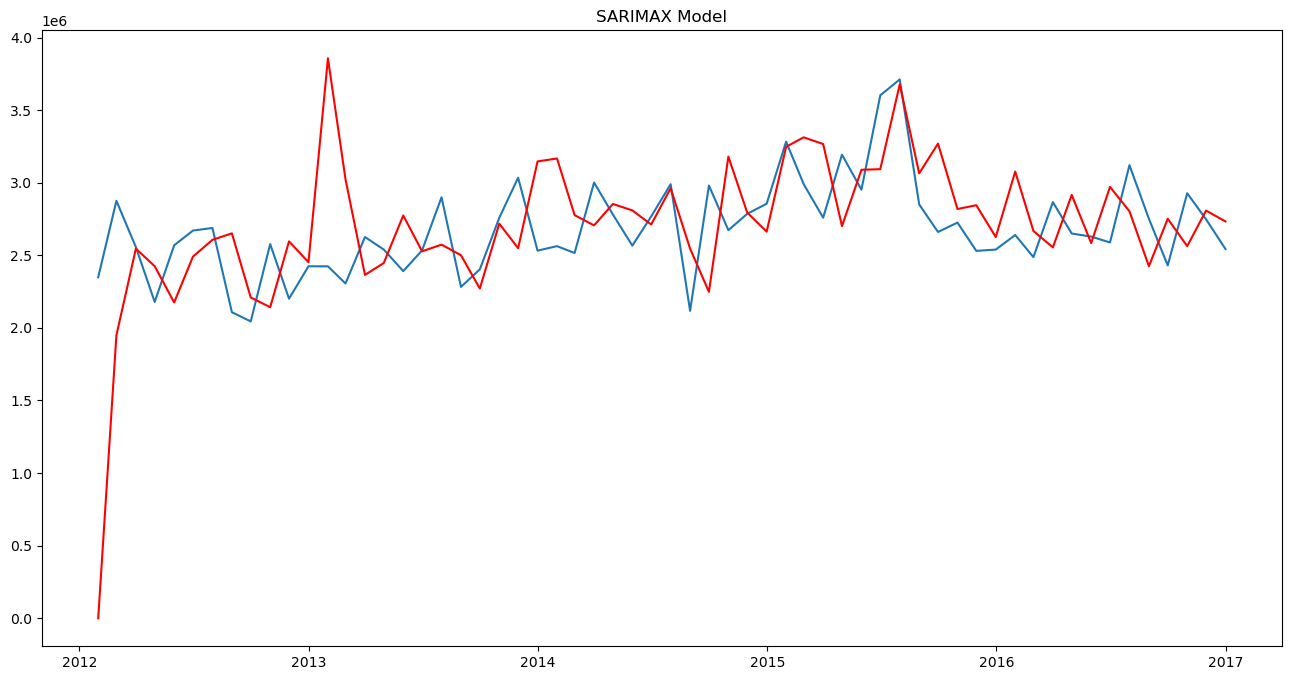

In [49]:
# #Trying a SARIMAX model
plt.figure(figsize = (16, 8))

# Using p = 12, d = 1, q = 3
model_SARIMAX = sm.tsa.statespace.SARIMAX(TrendOrderM, 
                                          order = (1, 1, 1),
                                          seasonal_order = (1,1,1,12))

results_SARIMAX = model_SARIMAX.fit()

plt.plot(TrendOrderM)

plt.plot(results_SARIMAX.fittedvalues, color = 'red')

plt.title('SARIMAX Model')

plt.show()

In [50]:
results_SARIMAX.aic

1342.5951815272974

### Tuning the SARIMAX Model

#### Testing SARIMAX values with ACF and PACF

<Figure size 1600x800 with 0 Axes>

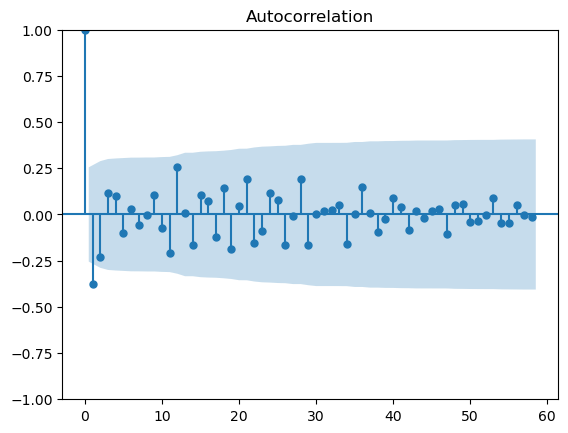

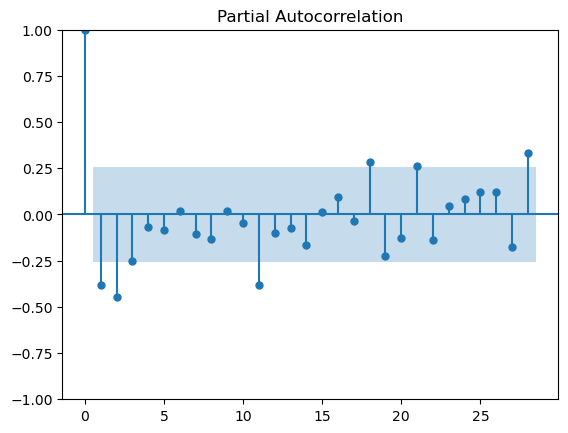

In [51]:
#Checking ACF and PACF plots
plt.figure(figsize = (16, 8))

plot_acf(TrendOrderM.diff().dropna(), lags = 58) 

plt.show()

plot_pacf(TrendOrderM.diff().dropna(), lags = 28) 

plt.show()

For d = 1, ACF shows q = 1 and PACF shows p = 2

C:\Users\lglay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


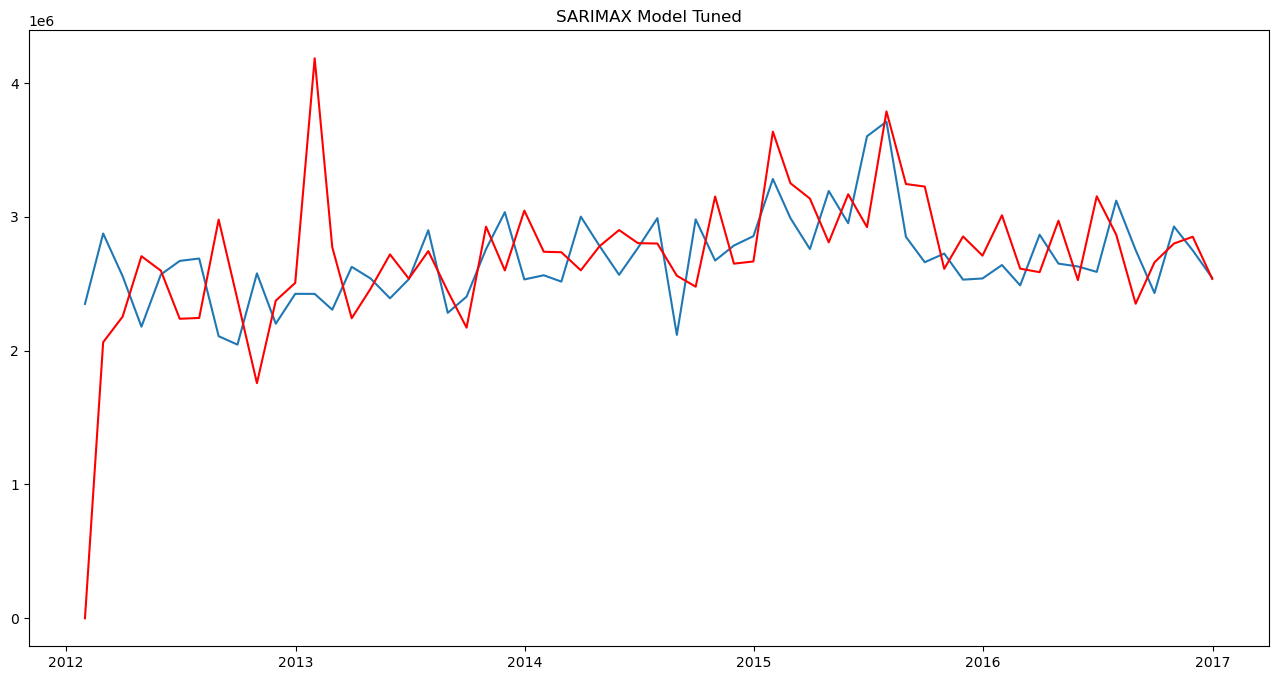

In [52]:
# #Trying a SARIMAX model
plt.figure(figsize = (16, 8))

# Using p = 11, d = 1, q = 1
model_SARIMAX_Tuned = sm.tsa.statespace.SARIMAX(TrendOrderM, 
                                          order = (3, 1, 3),
                                          seasonal_order = (2,1,1,12))

results_SARIMAX_Tuned = model_SARIMAX_Tuned.fit()

plt.plot(TrendOrderM)

plt.plot(results_SARIMAX_Tuned.fittedvalues, color = 'red')

plt.title('SARIMAX Model Tuned')

plt.show()

In [53]:
#Brute force parameter tuning. Create a matrix of pdq and seasonal pdq values to test.
import itertools
p = q = range(0, 4)
d = range (0,2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(pdq)]


In [54]:
# #Ignoring warnings from running code:
# from statsmodels.tools.sm_exceptions import ConvergenceWarning
# warnings.simplefilter('ignore', ConvergenceWarning)

# #Get the best params for the data. Choose the lowest AIC.

# #The code tests the given params using sarimax and outputs the AIC scores.
# Normal = []
# Seasonal = []
# AicCalc = []

# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(TrendOrderM,
#                                             order=param,
#                                             seasonal_order=param_seasonal,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)

#             results = mod.fit()
            
#             Normal.append(param)
#             Seasonal.append(param_seasonal)
#             AicCalc.append(results.aic)

#         except:
#             continue

In [55]:
# #Create dataframe and find minimum AIC value
# SARIMAXdf = pd.DataFrame({"pdq":Normal,
#                           "pdqs":Seasonal,
#                           "aic":AicCalc})

# MinAIC = SARIMAXdf.loc[SARIMAXdf["aic"] == SARIMAXdf["aic"].min()]


# print("The configuration with the lowest aic values is:","\n",MinAIC)

Muted code above due to run time - below are the values from the run.      
    
    The configuration with the lowest aic values is: 
            pdq           pdqs         aic
    231  (0, 1, 3)  (0, 1, 3, 12)  207.024371

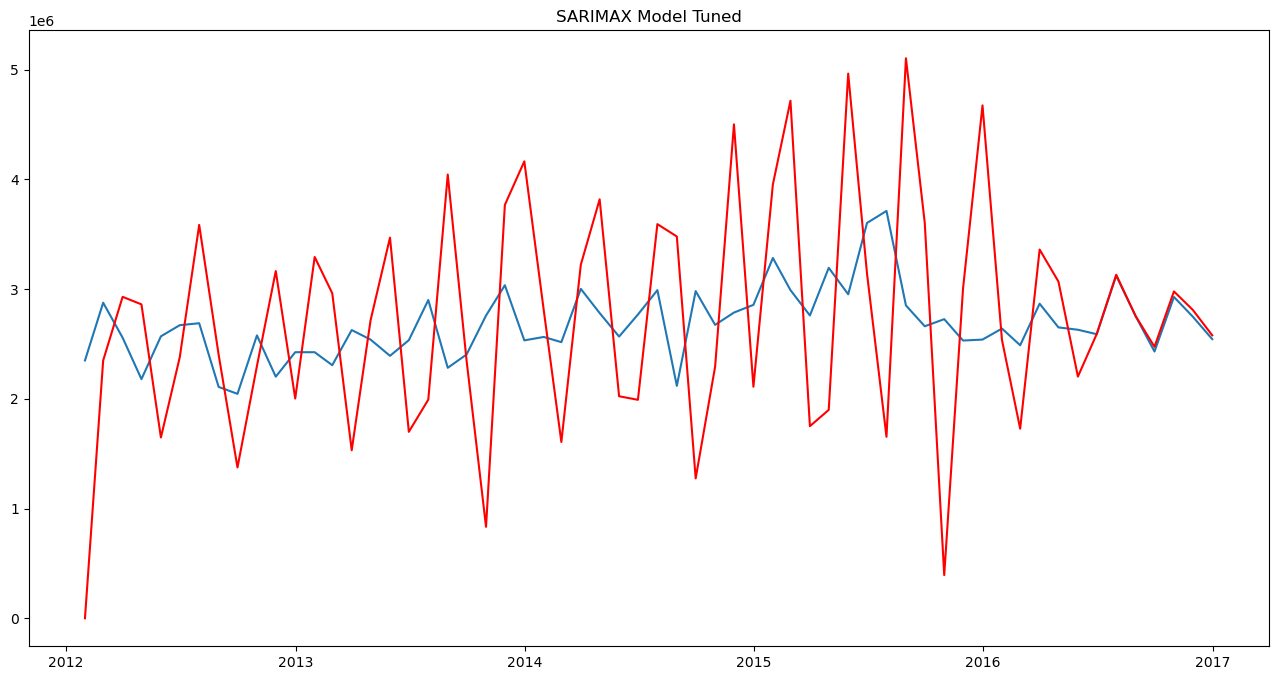

In [56]:
# #Trying a SARIMAX model
plt.figure(figsize = (16, 8))

# Using pdq and seasonal pdq values from above
model_SARIMAX_Tuned = sm.tsa.statespace.SARIMAX(TrendOrderM, 
                                          order = (0, 1, 3),
                                          seasonal_order = (0,1,3,12),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)

results_SARIMAX_Tuned = model_SARIMAX_Tuned.fit()

plt.plot(TrendOrderM)

plt.plot(results_SARIMAX_Tuned.fittedvalues, color = 'red')

plt.title('SARIMAX Model Tuned')

plt.show()

By not enforcing stationarity, the values show to be greatly varied from the original data set. We will rerun the brute force, this time adjusting **enforce_stationarity = True**
    
    **enforce_stationarity : bool, optional**    
        Whether or not to transform the AR parameters to enforce stationarity in the autoregressive component of the model. Default is True.

    **enforce_invertibility : bool, optional**
        Whether or not to transform the MA parameters to enforce invertibility in the moving average component of the model. Default is True.

In [57]:
print(results_SARIMAX_Tuned.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       Order_Demand   No. Observations:                   60
Model:             SARIMAX(0, 1, 3)x(0, 1, 3, 12)   Log Likelihood                 -96.512
Date:                            Tue, 14 Mar 2023   AIC                            207.024
Time:                                    14:48:11   BIC                            206.646
Sample:                                01-31-2012   HQIC                           202.345
                                     - 12-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1018     43.220      0.002      0.998     -84.608      84.812
ma.L2          0.6487     28.402   

In [58]:
(results_SARIMAX_Tuned.mse)**0.5

1069367.0712205605

In [59]:
# #Get the best params for the data. Choose the lowest AIC.

# #The code tests the given params using sarimax and outputs the AIC scores.
# Normal2 = []
# Seasonal2 = []
# AicCalc2 = []

# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod2 = sm.tsa.statespace.SARIMAX(TrendOrderM,
#                                             order=param,
#                                             seasonal_order=param_seasonal,
#                                             enforce_stationarity=True,
#                                             enforce_invertibility=False)

#             results2 = mod2.fit()
            
#             Normal2.append(param)
#             Seasonal2.append(param_seasonal)
#             AicCalc2.append(results2.aic)

#         except:
#             continue

In [60]:
# #Create dataframe and find minimum AIC value
# SARIMAXdf2 = pd.DataFrame({"pdq":Normal2,
#                           "pdqs":Seasonal2,
#                           "aic":AicCalc2})

# MinAIC2 = SARIMAXdf2.loc[SARIMAXdf2["aic"] == SARIMAXdf2["aic"].min()]


# print("The configuration with the lowest aic values is:","\n",MinAIC2)

Muted code above due to run time - below are the values from the run.    

    The configuration with the lowest aic values is: 
            pdq           pdqs   aic
    444  (1, 1, 1)  (3, 1, 1, 12)  14.0

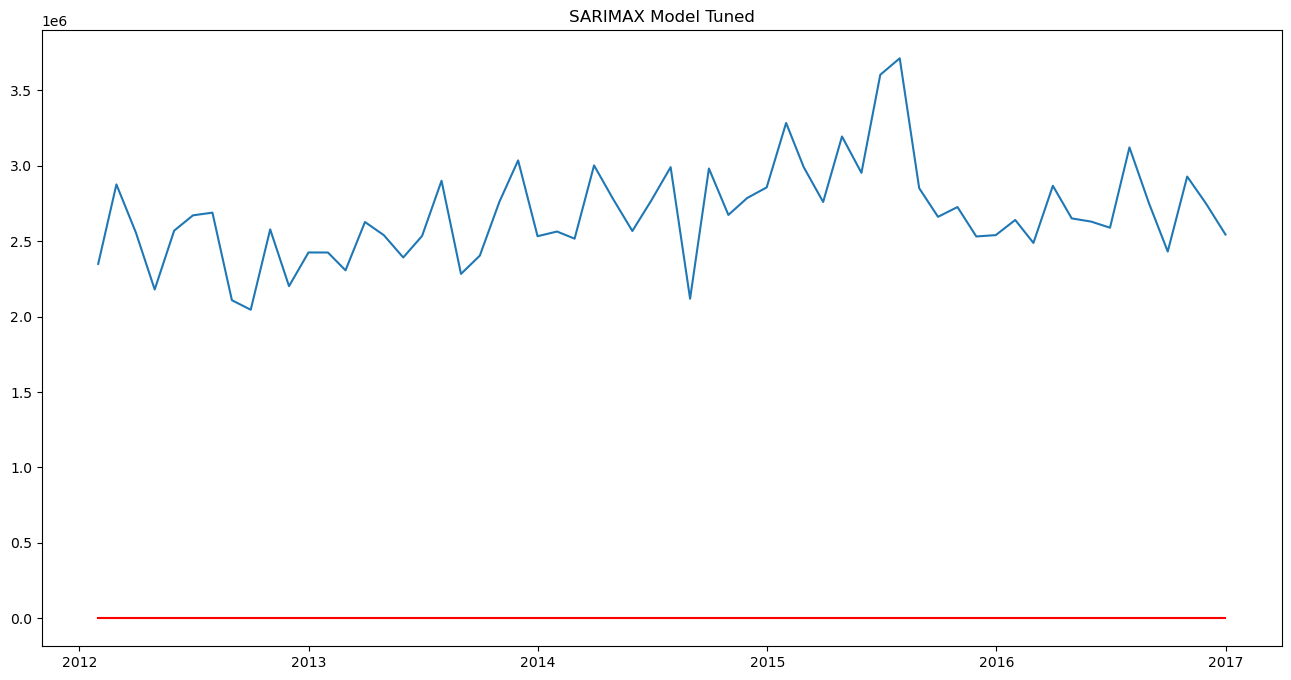

In [61]:
# #Trying a SARIMAX model
plt.figure(figsize = (16, 8))

# Using pdq and seasonal pdq values from above
model_SARIMAX_Tuned2 = sm.tsa.statespace.SARIMAX(TrendOrderM, 
                                          order = (1, 1, 1),
                                          seasonal_order = (3,1,1,12),
                                          enforce_stationarity=True,
                                          enforce_invertibility=False)

results_SARIMAX_Tuned2 = model_SARIMAX_Tuned2.fit()

plt.plot(TrendOrderM)

plt.plot(results_SARIMAX_Tuned2.fittedvalues, color = 'red')

plt.title('SARIMAX Model Tuned')

plt.show()

In [62]:
print(results_SARIMAX_Tuned2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       Order_Demand   No. Observations:                   60
Model:             SARIMAX(1, 1, 1)x(3, 1, 1, 12)   Log Likelihood                   0.000
Date:                            Tue, 14 Mar 2023   AIC                             14.000
Time:                                    14:48:12   BIC                             26.951
Sample:                                01-31-2012   HQIC                            18.874
                                     - 12-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9145   6.17e-09   1.48e+08      0.000       0.915       0.915
ma.L1         18.3405         -0   

Finding the lowest AIC looks to over simplify this model, causing the fitted values to center around 1. Will look at dataframe of minumum AIC values to test other combinations with low AIC to identify when the model stops fitting to the data.

In [63]:
# SARIMAXdf2.sort_values("aic").head(10)

	       pdq	        pdqs	        aic
    444	(1, 1, 1)	(3, 1, 1, 12)	14.000000
    165	(0, 1, 1)	(0, 1, 2, 12)	1340.926542
    179	(0, 1, 1)	(2, 1, 0, 12)	1341.126578
    166	(0, 1, 1)	(0, 1, 3, 12)	1341.235350
    173	(0, 1, 1)	(1, 1, 2, 12)	1341.315753
    147	(0, 1, 0)	(2, 1, 0, 12)	1341.646829
    421	(1, 1, 1)	(0, 1, 2, 12)	1342.060679
    435	(1, 1, 1)	(2, 1, 0, 12)	1342.120262
    187	(0, 1, 1)	(3, 1, 0, 12)	1342.254629
    645	(2, 1, 0)	(0, 1, 2, 12)	1342.282039

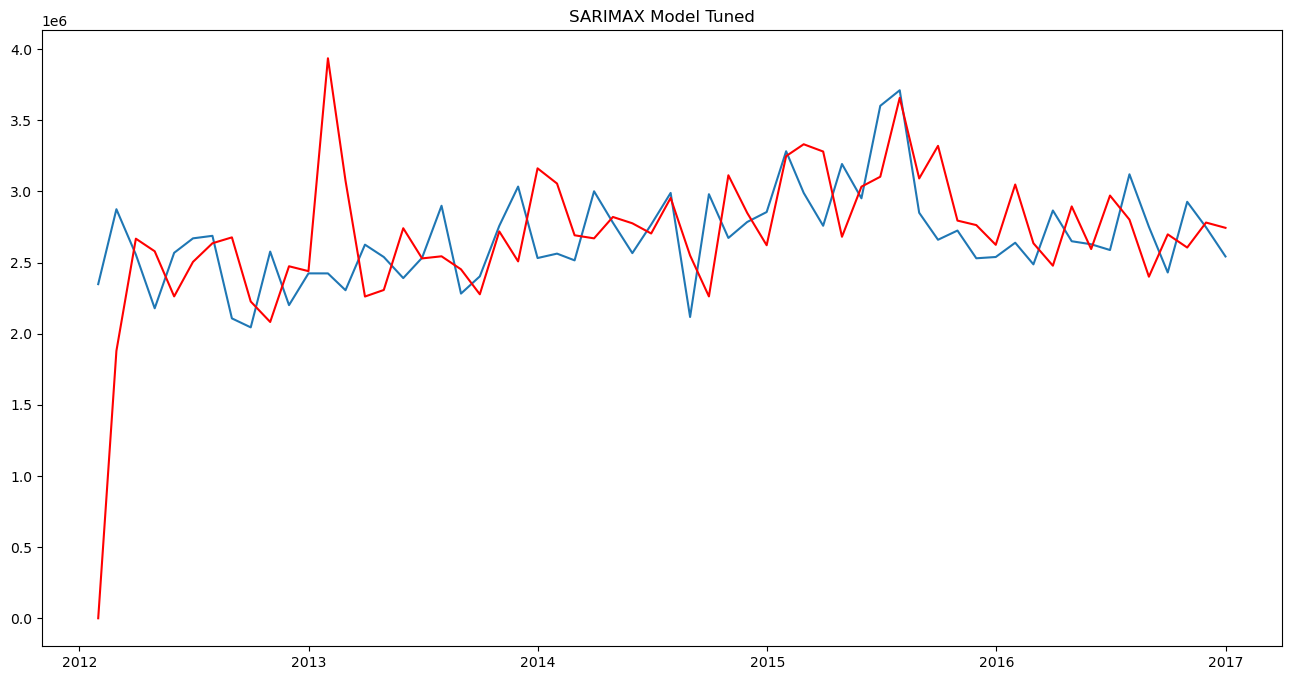

In [64]:
# #Trying a SARIMAX model
plt.figure(figsize = (16, 8))

# Using pdq and seasonal pdq values from above
model_SARIMAX_Tuned3 = sm.tsa.statespace.SARIMAX(TrendOrderM, 
                                          order = (0, 1, 1),
                                          seasonal_order = (0,1,2,12),
                                          enforce_stationarity=True,
                                          enforce_invertibility=False)

results_SARIMAX_Tuned3 = model_SARIMAX_Tuned3.fit()

plt.plot(TrendOrderM)

plt.plot(results_SARIMAX_Tuned3.fittedvalues, color = 'red')

plt.title('SARIMAX Model Tuned')

plt.show()

In [65]:
print(results_SARIMAX_Tuned3.summary())

                                        SARIMAX Results                                        
Dep. Variable:                            Order_Demand   No. Observations:                   60
Model:             SARIMAX(0, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood                -666.463
Date:                                 Tue, 14 Mar 2023   AIC                           1340.927
Time:                                         14:48:12   BIC                           1348.327
Sample:                                     01-31-2012   HQIC                          1343.711
                                          - 12-31-2016                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2084      0.122     -1.704      0.088      -0.448       0

In [66]:
(results_SARIMAX_Tuned3.mse)**0.5

506084.0216024186

In [67]:
# #Get the best params for the data. Choose the lowest AIC.

# #The code tests the given params using sarimax and outputs the AIC scores.
# Normal4 = []
# Seasonal4 = []
# AicCalc4 = []

# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod4 = sm.tsa.statespace.SARIMAX(TrendOrderM,
#                                             order=param,
#                                             seasonal_order=param_seasonal,
#                                             enforce_stationarity=True,
#                                             enforce_invertibility=True)

#             results4 = mod4.fit()
            
#             Normal4.append(param)
#             Seasonal4.append(param_seasonal)
#             AicCalc4.append(results4.aic)

#         except:
#             continue

In [68]:
# #Create dataframe and find minimum AIC value
# SARIMAXdf4 = pd.DataFrame({"pdq":Normal4,
#                           "pdqs":Seasonal4,
#                           "aic":AicCalc4})

# MinAIC4 = SARIMAXdf4.loc[SARIMAXdf4["aic"] == SARIMAXdf4["aic"].min()]


# print("The configuration with the lowest aic values is:","\n",MinAIC4)

Muted code above due to run time - below are the values from the run.    
    
    The configuration with the lowest aic values is: 
            pdq           pdqs          aic
    164  (0, 1, 1)  (0, 1, 1, 12)  1340.344533

In [69]:
# SARIMAXdf4.sort_values("aic").head(10)

  	    pdq         	pdqs	     aic
    164	(0, 1, 1)	(0, 1, 1, 12)	1340.344533
    140	(0, 1, 0)	(1, 1, 1, 12)	1340.853424
    165	(0, 1, 1)	(0, 1, 2, 12)	1340.926542
    179	(0, 1, 1)	(2, 1, 0, 12)	1341.126578
    166	(0, 1, 1)	(0, 1, 3, 12)	1341.235350
    173	(0, 1, 1)	(1, 1, 2, 12)	1341.315753
    420	(1, 1, 1)	(0, 1, 1, 12)	1341.461419
    172	(0, 1, 1)	(1, 1, 1, 12)	1341.464780
    644	(2, 1, 0)	(0, 1, 1, 12)	1341.601277
    180	(0, 1, 1)	(2, 1, 1, 12)	1341.638369

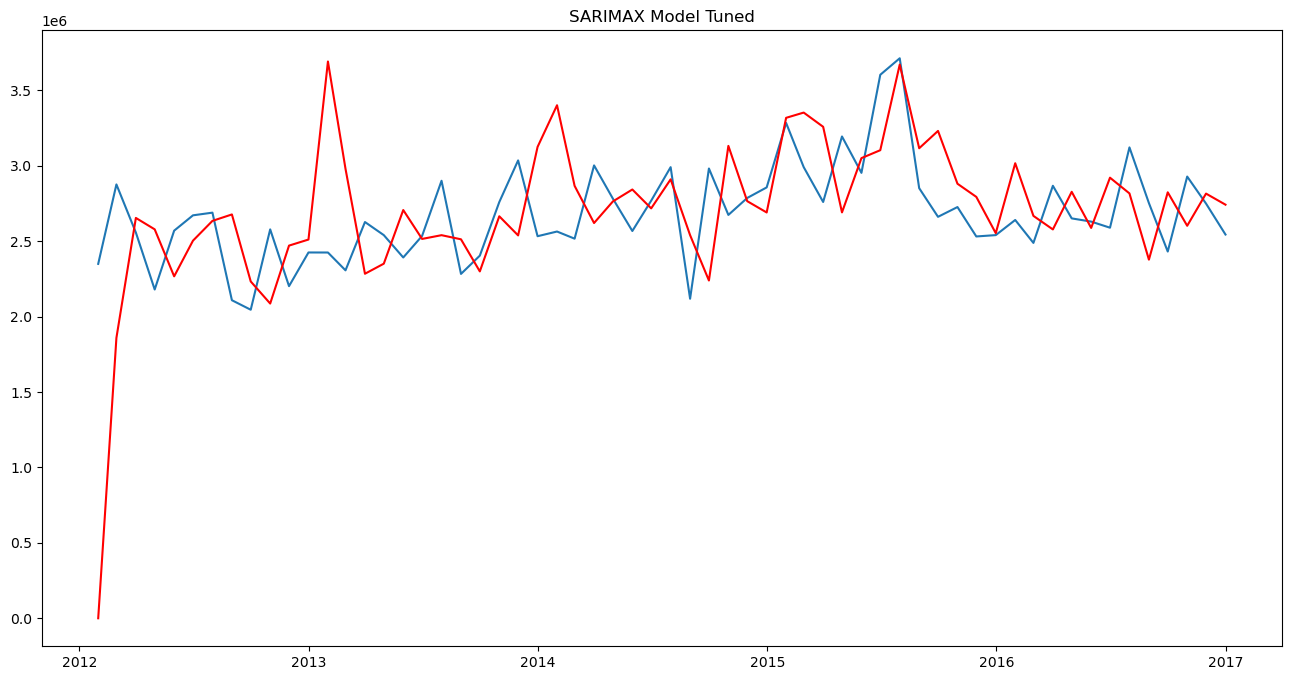

In [70]:
# #Trying a SARIMAX model
plt.figure(figsize = (16, 8))

# Using pdq and seasonal pdq values from above
model_SARIMAX_Tuned4 = sm.tsa.statespace.SARIMAX(TrendOrderM, 
                                          order = (0, 1, 1),
                                          seasonal_order = (0,1,1,12),
                                          enforce_stationarity=True,
                                          enforce_invertibility=True)

results_SARIMAX_Tuned4 = model_SARIMAX_Tuned4.fit()

plt.plot(TrendOrderM)

plt.plot(results_SARIMAX_Tuned4.fittedvalues, color = 'red')

plt.title('SARIMAX Model Tuned')

plt.show()

In [71]:
print(results_SARIMAX_Tuned4.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       Order_Demand   No. Observations:                   60
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -667.172
Date:                            Tue, 14 Mar 2023   AIC                           1340.345
Time:                                    14:48:12   BIC                           1345.895
Sample:                                01-31-2012   HQIC                          1342.433
                                     - 12-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2188      0.122     -1.789      0.074      -0.458       0.021
ma.S.L12      -0.6900      0.231   

In [72]:
(results_SARIMAX_Tuned4.mse)**0.5

499461.81350548257

This model shows the lowest RMSE value of any of the models tuned.

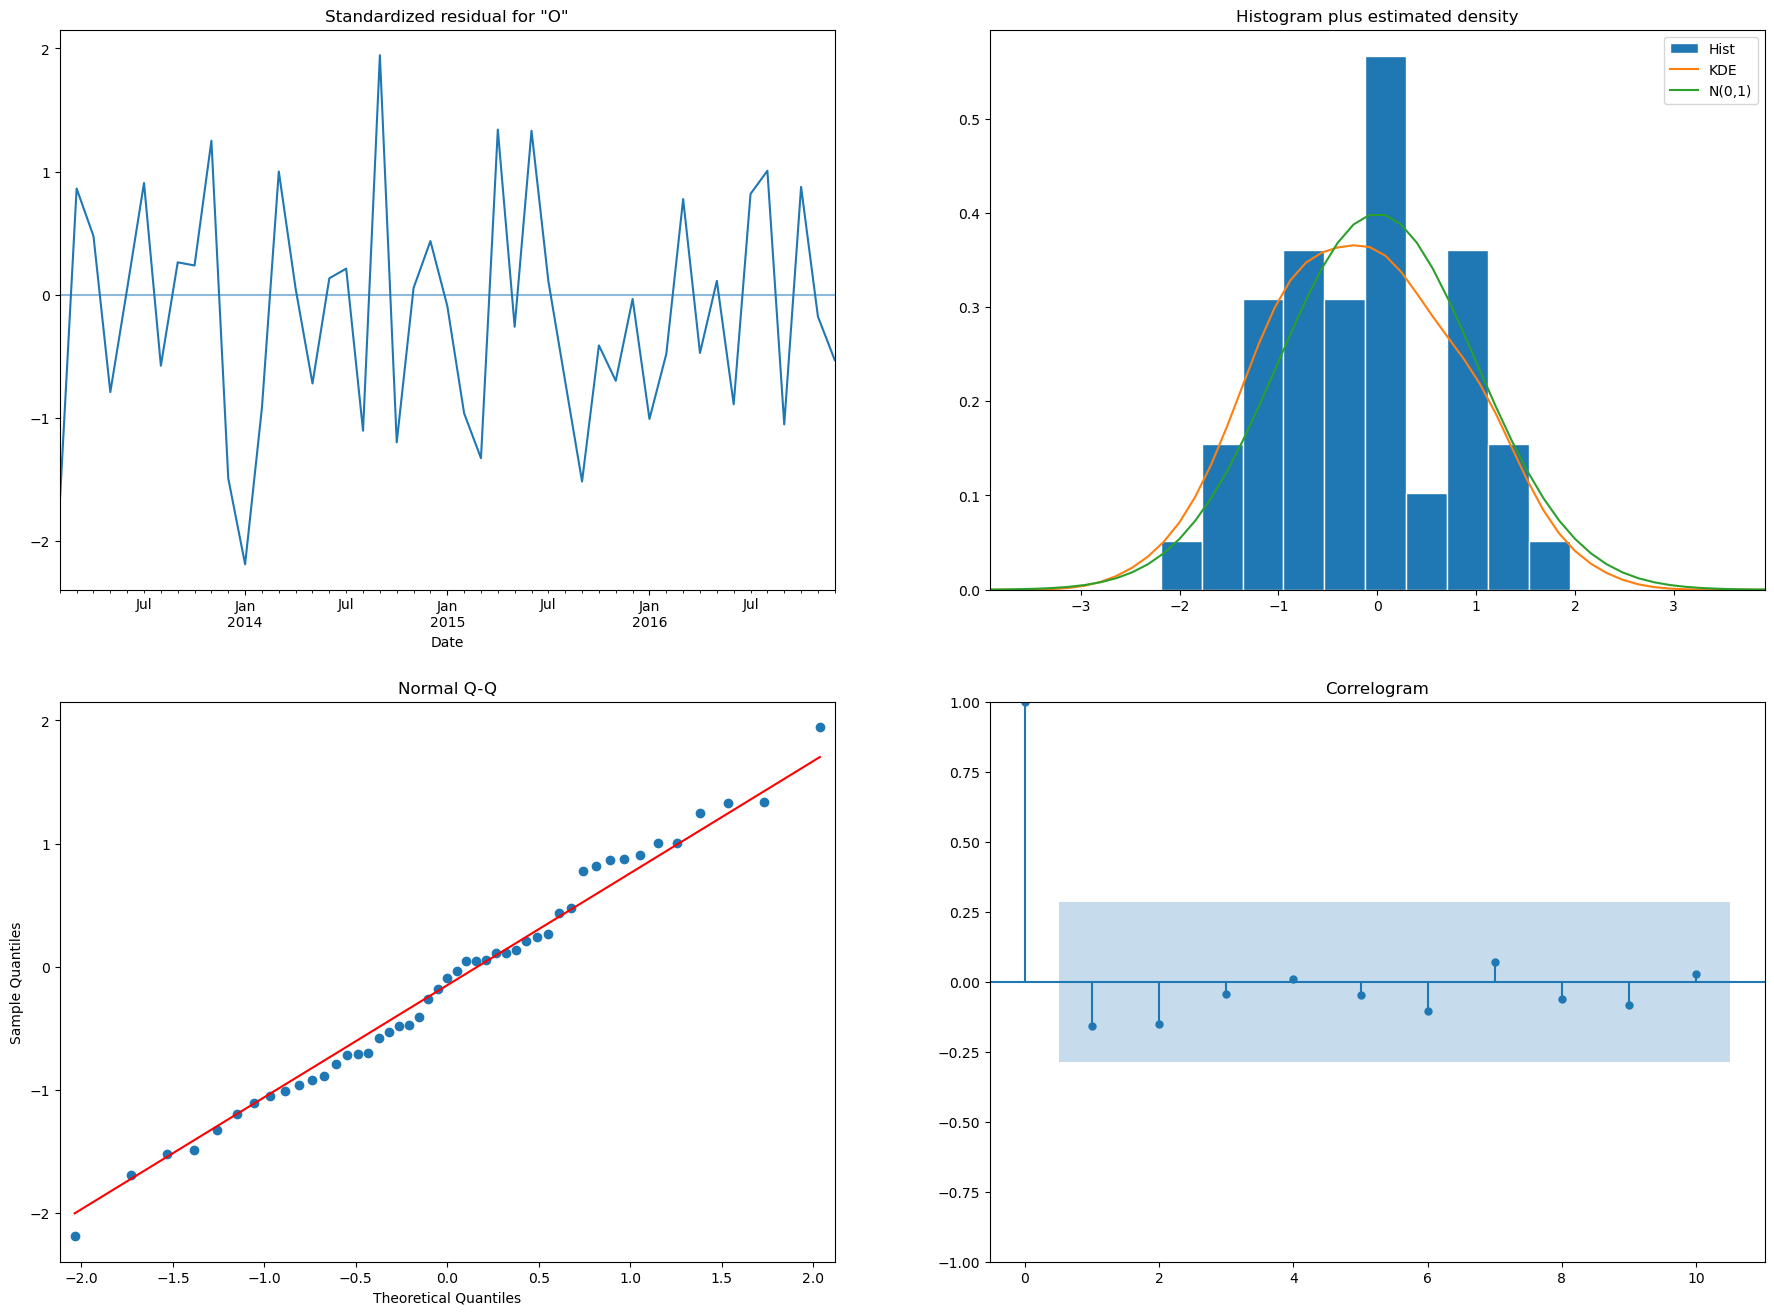

In [73]:
results_SARIMAX_Tuned4.plot_diagnostics(figsize=(22, 16))
plt.show()

#### Observations 
* **The standardize residual plot**: The residuals over time don’t display any obvious patterns. They appear as white noise.
* **The Normal Q-Q-plot**: Shows that the ordered distribution of residuals follows the linear trend.
* **Histogram and estimated density plot**: The KDE nearly follows the N(0,1) line 
* **The Correlogram plot**: Shows that the time series residuals have low correlation with lagged versions of itself. Thus, there are no patterns left to extract in the residuals.

### Checking Model Prediction

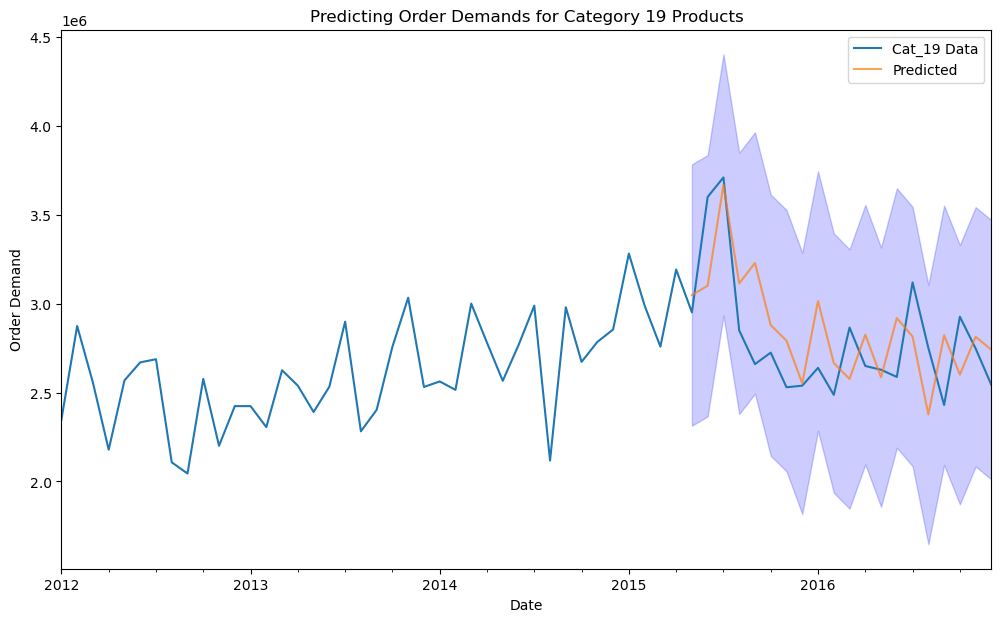

In [74]:
#Lets get the predictions and confidence interval for those predictions.
#Get the predictions.
pred_comp = results_SARIMAX_Tuned4.get_prediction(start=pd.to_datetime('2015-05-31'), 
                                             dynamic=False)

# dynamic : bool, int, str, or datetime, optional
    # Integer offset relative to start at which to begin dynamic prediction. 
    # Can also be an absolute date string to parse or a datetime type 
    # (these are not interpreted as offsets). 
    # Prior to this observation, true endogenous values will be used for prediction; 
    # starting with this observation and continuing through the end of prediction, 
    # forecasted endogenous values will be used instead.
    
#Confidence interval.
pred_comp_ci = pred_comp.conf_int()

#Plotting real and forecasted values.
ax = TrendOrderM['2012':].plot(label='Cat_19 Data', figsize=(12, 7))
pred_comp.predicted_mean.plot(ax=ax, label='Predicted', alpha=.7)
ax.fill_between(pred_comp_ci.index,
                pred_comp_ci.iloc[:, 0],
                pred_comp_ci.iloc[:, 1], color='blue', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Order Demand')
ax.set_title("Predicting Order Demands for Category 19 Products")
plt.legend()
plt.show()


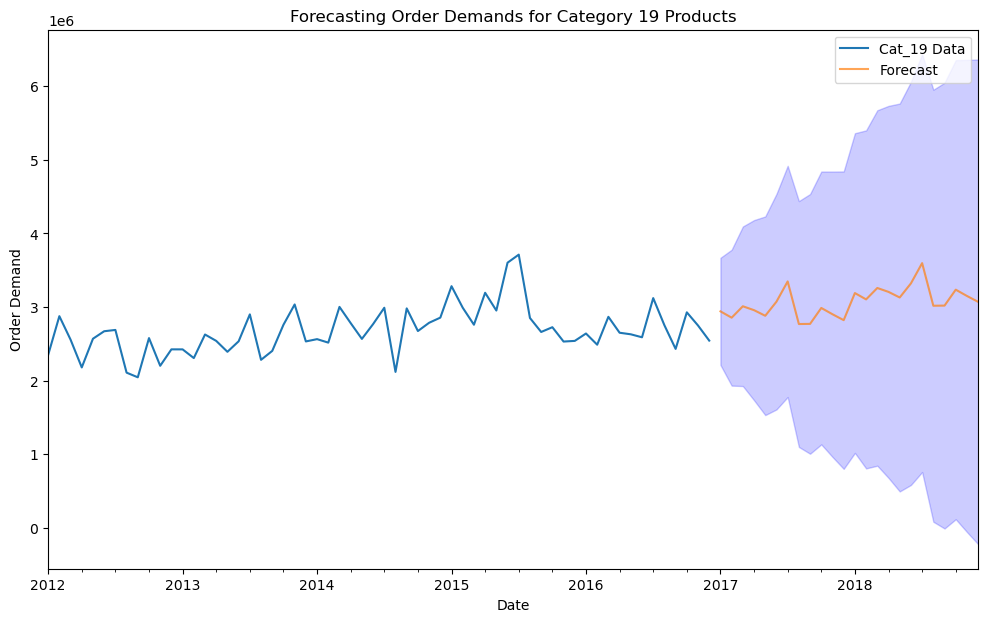

In [75]:
#Get the forecasted values.
pred_forecast = results_SARIMAX_Tuned4.get_forecast(steps = 24)
    
#Confidence interval.
pred_forecast_ci = pred_forecast.conf_int()

#Plotting real and forecasted values.
ax = TrendOrderM.plot(label='Cat_19 Data', figsize=(12, 7))
pred_forecast.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)
ax.fill_between(pred_forecast_ci.index,
                pred_forecast_ci.iloc[:, 0],
                pred_forecast_ci.iloc[:, 1], color='blue', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Order Demand')
ax.set_title("Forecasting Order Demands for Category 19 Products")
plt.legend()
plt.show()

Predicted values are well within confidence interval, and forecasted data seems to follow general trend of order demand based on previous data. This model should be able to be used to begin predicting order demand to more effectively stock warehousees with product.

Next steps would be to begin setting up a function to process and run model tests on data from different categories and product codes to narrow down predictions to a smaller subset. This will be explored in the next step of this process to see what automation could be done in assistance in future modeling.

Reference:

https://www.jadsmkbdatalab.nl/forecasting-with-sarimax-models/ 